# Exploratory Data Analysis en el mercado cripto.

In [1178]:
# import numpy as np
import pandas as pd
# from numba import jit,njit
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from matplotlib.ticker import MultipleLocator,MaxNLocator,FormatStrFormatter,StrMethodFormatter
from matplotlib.dates import YearLocator,DateFormatter
import random

In [46]:
sns.set()
%matplotlib inline
sns.set(rc={"figure.figsize": (17.75,9)}) # Tamaño de las figuras
%config Completer.use_jedi = False # Autocompletar más rápido
pd.options.display.float_format = "{:.2f}".format # Mostrar solo dos decimales en pandas
sns.set_style('whitegrid')

### Estructura de los datasets

Primero veamos, en las 2 celdas siguientes, los datos por separado de ambas fuentes para conocer su estructura y entender mejor cómo trabajar con ellos.

In [428]:
cg_btc = pd.read_csv('CoinGecko/data/btc.csv')
cg_btc['Fecha'] = pd.to_datetime(cg_btc.Fecha)
cg_btc['BTC_Volumen'] = cg_btc.Volumen / cg_btc.Precios
# cg_btc = cg_btc[['Fecha','Market_Cap','Volumen','BTC_Volumen']]
cg_btc.columns = ['Fecha','Precios','Market_Cap','USD_Volumen','BTC_Volumen']

bn_btc = pd.read_csv('Binance/data/by1d/btcusdt.csv')
bn_btc['Fecha'] = pd.to_datetime(bn_btc.Fecha)

bn_btc.head(1)

Fecha    Abre    Alto    Bajo  Cierra  BTC_Volumen  USDT_Volumen
0 2017-08-17 4261.48 4485.39 4200.74 4285.08       795.15    3454770.05

In [429]:
cg_btc.head(1)

Fecha  Precios    Market_Cap  USD_Volumen  BTC_Volumen
0 2013-04-30   135.30 1501657493.00         0.00         0.00

# Inconsistencias con los datos de volumen?

Lo que sucede es que coingecko rastrea el volúmen de transacción en, a la fecha de hoy, 821 intercambios a nivel mundial. De todos esos intercambios, rastrea todo el volumen de bitcoin a través de todos los pares de cada intercambio.

Es debido a ello que la cantidad en volumen difiera con la de binance, ya que binance solo nos entrega el volumen que ellos procesan, además, no estamos contabilizando el volumen total a través de todos los pares de binance, sino solo a través del par BTCUSDT. Si deseamos algo más acercado a la realidad del exchange binance y su participación total relativa al volumen total de btc en los 821 intercambios de coingecko, deberíamos sumar el volumen de btc de cada par listado en binance.

Para las diferencias con el volumen solo hace falta ver los datos de una sola cripto.

Veamos las conclusiones a continuación con el siguiente dataframe.

In [450]:
df = bn_btc[['Fecha','Cierra','BTC_Volumen','USDT_Volumen']]
df.columns = ['Fecha','Precios','BTC_Volumen','USDT_Volumen']
df = df.merge(cg_btc,suffixes=('_bn','_cg'),how='left',on='Fecha')
df.head(5)

Fecha  Precios_bn  BTC_Volumen_bn  USDT_Volumen  Precios_cg  \
0 2017-08-17     4285.08          795.15    3454770.05     4286.92   
1 2017-08-18     4108.37         1199.89    5086958.31     4097.69   
2 2017-08-19     4139.98          381.31    1549483.74     4115.21   
3 2017-08-20     4086.29          467.08    1930364.39     4001.23   
4 2017-08-21     4016.00          691.74    2797231.71     3935.23   

      Market_Cap   USD_Volumen  BTC_Volumen_cg  
0 70778773053.66 1774245121.03       413874.34  
1 67671539511.39 1515069151.86       369737.76  
2 67968693045.18 1710080500.02       415551.01  
3 66092742688.79  551798951.97       137907.38  
4 65008176478.94  712634899.40       181091.04

En el dataframe anterior vemos cómo difieren las cantidades entre USD_Volumen y USDT_Volumen

# Inconsistencias con los datos de precios?

Debido a que CoinGecko no es un exchange, no podemos fiarnos de sus precios para hacer transacciones, por lo que, en primera instancia, un análisis apropiado se debería de realizar con los datos con los que se van a trabajar en realidad, sin embargo, para propósitos de calidad en nuestro análisis, vamos a ver qué tan diferentes son los datos de precios entre CoinGecko y un intercambio como Binance. En la página de CoinGecko ya nos dicen que sus precios están calculados con base en una ecuación dada por ellos. Aquí solo vamos a verificar dicha diferencia y a cuantificarla.

Aquí debemos analizar la totalidad de las criptos que estamos trabajando.

In [693]:
# Lo que se hace aquí es cargar todos los datos en DF's, para después hacer un .merge() de todos ellos, tanto los de binance como los de coingecko. Se realizan algunas transformaciones.
dfc = []
crl = []
for i in [i for i in os.listdir('CoinGecko/data') if '_' not in i]:
    path = f'CoinGecko/data/{i}'
    crl.append(i.replace('.csv',''))
    dfc.append(pd.read_csv(path))
    if crl[-1] == 'btc':
        dfc = [dfc.pop()] + dfc
        crl = [crl.pop()] + crl

j = 0
for i in dfc:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i = i[['Fecha','Precios']]
    i.columns = ['Fecha',f'{crl[j].upper()}']
    if j == 0:
        df_cgp = i
    else:
        df_cg = df_cgp.merge(i,how='left',on='Fecha')
    j += 1
    
dfx = pd.melt(df_cgp,id_vars='Fecha',value_vars=list(df_cgp.columns).remove('Fecha'),var_name='Criptos')

dfb = []
for i in [i for i in os.listdir('Binance/data/by1d/') if '_' not in i]:
    path = f'Binance/data/by1d/{i}'
    dfb.append(pd.read_csv(path))
    if i.replace('usdt.csv','') == 'btc':
        dfb = [dfb.pop()] + dfb
    
j = 0
for i in dfb:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i = i[['Fecha','Cierra']]
    i.columns = ['Fecha',f'{crl[j].upper()}']
    if j == 0:
        df_bnp = i
    else:
        df_bnp = df_bnp.merge(i,how='left',on='Fecha')
    j += 1
    
dfy = pd.melt(df_bnp,id_vars='Fecha',value_vars=list(df_bnp.columns).remove('Fecha'),var_name='Criptos')

comparativa_precios = dfx.merge(dfy,on=['Fecha','Criptos']).rename(columns={'value_x':'Precio_cg','value_y':'Precio_bn'})
comparativa_precios['Diferencia'] = abs(comparativa_precios['Precio_cg'] - comparativa_precios['Precio_bn'])

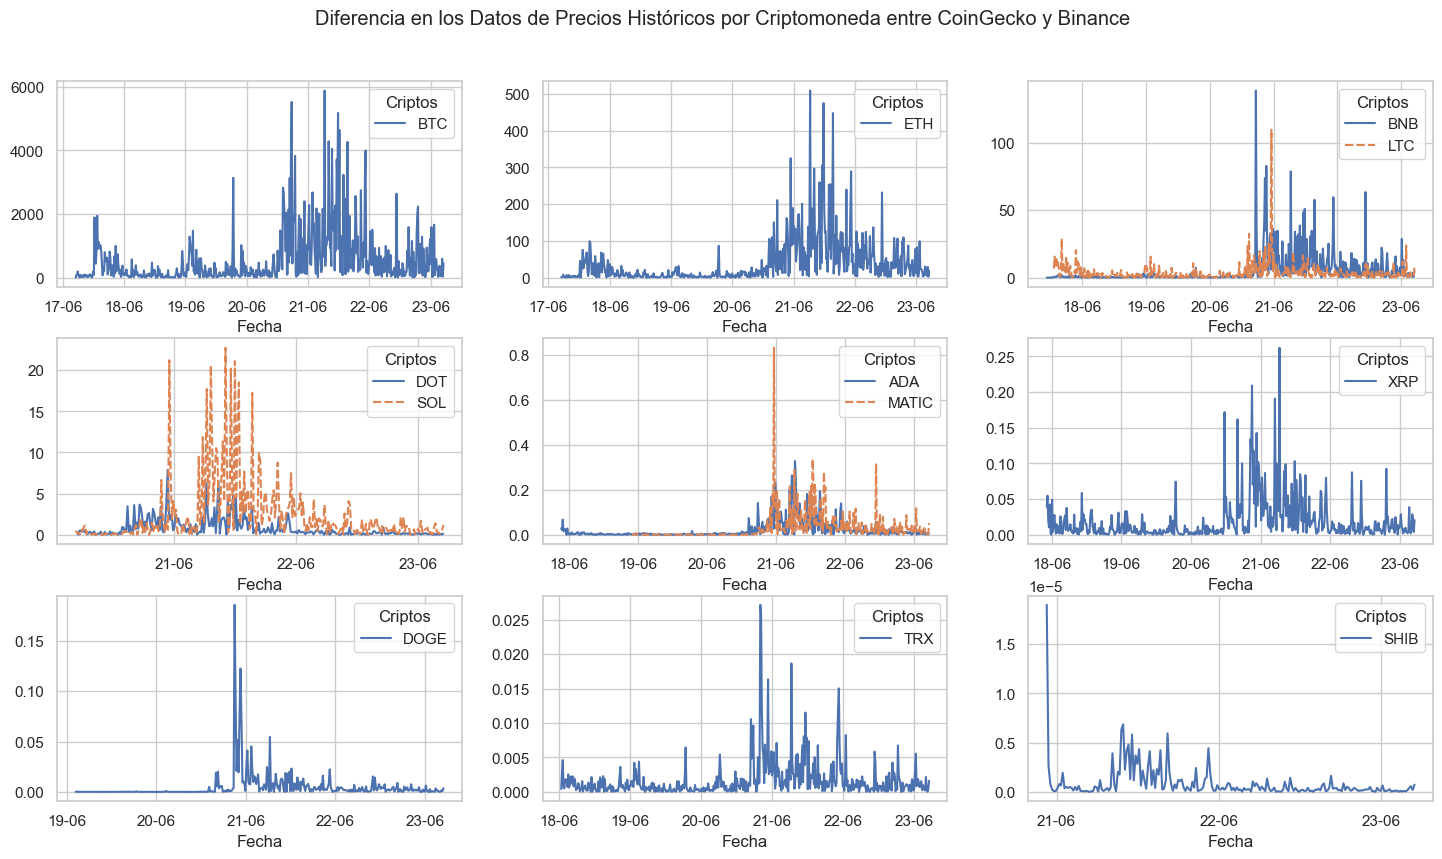

In [659]:

fig = plt.figure()
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.25)
fig.suptitle('Diferencia en los Datos de Precios Históricos por Criptomoneda entre CoinGecko y Binance')

lista = []
plots = ['BTC','ETH',['BNB','LTC'],['SOL','DOT'],['MATIC','ADA'],'XRP','DOGE','TRX','SHIB']
for i in range(1,10):
    lista.append(fig.add_subplot(330+i))
    
for ax in lista:
    ax.xaxis.set_major_locator(YearLocator(1, month=6, day=1))
    ax.xaxis.set_major_formatter(DateFormatter('%y-%m'))

j = 0
for i in plots:
    if type(i) == str:
        sns.lineplot(comparativa_precios[comparativa_precios.Criptos == i][::4].groupby(['Fecha','Criptos'])['Diferencia'].first().unstack(),ax=lista[j])
    elif type(i) == list:
        sns.lineplot(comparativa_precios[comparativa_precios.Criptos.isin(i)][::4].groupby(['Fecha','Criptos'])['Diferencia'].first().unstack(),ax=lista[j])
    j += 1
plt.show()

### Primera conclusión.

Podemos concluir que, para un análisis más acertado, tenemos los siguientes puntos:

    * Debido a que coingecko no es un exchange, debemos utilizar los precios del exchange en el que se quiera operar, ya que es ahí donde haremos la operación, no en coingecko. Además, en las gráficas anteriores, vemos que para las principales criptomonedas (BTC, ETH, BNB, LTC, SOL, DOT) existe una diferencia de precio significativa entre CoinGecko y el intercambio en cuestión.

    * Sería más apropiado agregar a nuestro análisis, al menos los principales exchanges para verificar diferencias de precios entre los mismos. Incluso esta estrategia podría identificar diferencias de precios lo suficientemente buenas como para hacer trading entre exchanges mediante transferencias de XRP, aunque esto último son casos excepcionales. En un sentido más técnico, las variaciones de precio entre exchanges, así como sus variaciones en volumen, podrían aportar datos relevantes por medio de un análisis de IA. 
    
    Además, la visualización de la celda anterior podría marcarnos la pauta de cuándo verificar datos de diferentes intercambios. Esto es así porque, si existe mucha diferencia entre el precio de un intercambio y el precio de coingecko, significaría, bajo nuestras conclusiones, que en otros intercambios el precio tendría un precio distinto. Sin embargo, esto último debemos verificarlo con datos de otros intercambios, esta verificación nos diría si la variación entre precios en intercambios es lo suficiente como para que sea una estrategia rentable el trading entre intercambios (entendiendo "trading entre intercambios"a la acción de hacer trading entre la cripto elegida y XRP para trasferir dichos activos entre intercambios para comprar la cripto elegida, pero más barata, siendo el beneficio de aumentar la tenencia en cripto pero sin aumentar el capital).

    * Considerando los dos puntos anteriores, se concluye que es una buena combinación utilizar el precio del exchange para un determinado par, como BTCUSDT, pero el volumen general indicado por coingecko. Ya que si bien el precio del exchange es el importante para las operaciones, el valor del volumen total nos da más información sobre tendencias del mercado en general, y como sabemos que es el mercado en general el que mueve el precio de BTC y no solo el mercado interno de binance, tiene sentido utilizar el volumen del mercado para obtener más información en vez de limitarse a la información de un solo exchange.

Al respecto de lo último, no sé si la combinación del volumen de binance junto con el general, aporte algo de valor en el análisis, por lo que dejaremos de lado los datos de volumen de binance. Así como también dejaremos de lado agregar datos de otros intercambios, nos limitaremos a coingecko y binance en lo que podamos hacer coincidir sus datos.

También vamos a prescindir de la columna de Precios_cg, ya que solo nos sirvió para verificar que solo es un valor de referencia y no de trabajo.

# =========================================================
# Integrando todas las criptos a trabajar

En la siguiente sección vamos a utilizar nuestro desarrollo de la celda de código anterior para generar las nuevas gráficas que van a darnos una mejor perspectiva de estos simples datos a nivel de todas las criptomonedas juntas.

In [1070]:
# Los siguientes ciclos tienen como objetivo la generalización de ciertos procedimientos a todos los DF's almacenados en la lista. Además de unirlos todos mediante merge().
j = 0
for i in dfc:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i[f'{coins[j]}_Volumen'] = i.Volumen / i.Precios
    i = i[['Fecha','Precios','Market_Cap','Volumen',f'{crl[j]}_Volumen']]
    i.columns = ['Fecha',f'Precio_{crl[j].upper()}_USD_cg',f'Market_Cap_{crl[j].upper()}_cg',f'USD_Volumen_{crl[j].upper()}_cg',f'{crl[j].upper()}_Volumen_cg']
    
    if j == 0:
        df_cg = i
    else:
        df_cg = df_cg.merge(i,how='left',on='Fecha')
    j += 1

j = 0
for i in dfb:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i.columns = [f'Fecha', f'Abre_{crl[j].upper()}', f'Alto_{crl[j].upper()}', f'Bajo_{crl[j].upper()}', f'Precio_{crl[j].upper()}_USDT_bn', f'{crl[j].upper()}_Volumen_bn',f'USDT_Volumen_{crl[j].upper()}_bn']
    if j == 0:
        df_bn = i
    else:
        df_bn = df_bn.merge(i,how='left',on='Fecha')
    j += 1
    
# Por último ordeno las columnas por orden alfabético
df_bn = df_bn[sorted(df_bn.columns)]
df_cg = df_cg[sorted(df_cg.columns)]

##### Uso de máscaras para filtrar columnas de nuestro DF y organizarlas.

In [1071]:
cols_cg = df_cg.columns
mc_str_cg = [i for i in cols_cg if 'Market_Cap' in i]
usv_str_cg = [i for i in cols_cg if 'USD_Volumen' in i]
crv_str_cg = [i for i in cols_cg if 'USD_Volumen' not in i and 'Market_Cap' not in i and 'Fecha' not in i and 'Precio' not in i]
pre_str_cg = [i for i in cols_cg if 'Precio' in i]

cols_cg = []
for i in range(len(mc_str)):
    if i == 0:
        cols_cg.append('Fecha')
    cols_cg.append(mc_str_cg[i]), cols_cg.append(pre_str_cg[i]), cols_cg.append(usv_str_cg[i]), cols_cg.append(crv_str_cg[i])
df_cg = df_cg[cols_cg]

cols_bn = df_bn.columns
op_str_bn = [i for i in cols_bn if 'Abre' in i]
hi_str_bn = [i for i in cols_bn if 'Alto' in i]
lo_str_bn = [i for i in cols_bn if 'Bajo' in i]
pre_str_bn = [i for i in cols_bn if 'Precio' in i]
usv_str_bn = [i for i in cols_bn if 'USDT_Volumen' in i]
crv_str_bn = [i for i in cols_bn if 'Volumen_bn' in i]

cols_bn = []
for i in range(len(op_str)):
    if i == 0:
        cols_bn.append('Fecha')
    cols_bn.append(op_str_bn[i]), cols_bn.append(hi_str_bn[i]), cols_bn.append(lo_str_bn[i]), cols_bn.append(pre_str_bn[i]), cols_bn.append(usv_str_bn[i]), cols_bn.append(crv_str_bn[i]) 
df_bn = df_bn[cols_bn]

### Funcionamiento de los DF.

Vamos a utilizar los dataframes anteriores para generar correlaciones entre parámetros de todas las criptomonedas juntas. Regresaremos a esto más adelante. El tratamiento de los dos DF's de las dos celdas anteriores y el de los DF's que estamos por crear es totalmente distinto.

### Uso de la función pd.melt()

Lo que haremos a continuación es un "unpivot" de nuestro dataframe con respecto a los tres parámetros de las 12 criptomonedas que estamos considerando. Esto lo haremos para poder dividir la información en DF's que la contengan, separada por el tipo de parámetro. 

Para separar por el tipo de parámetro, utilizaremos las máscaras creadas unas celdas arriba.

In [773]:
dfx = pd.melt(df_cg,id_vars='Fecha',value_vars=mc_str_cg + crv_str_cg + usv_str_cg,var_name='Criptomoneda',value_name='Valor')

crv_df = dfx[dfx['Criptomoneda'].isin(crv_str_cg)].reset_index(drop=True)
usv_df = dfx[dfx['Criptomoneda'].isin(usv_str_cg)].reset_index(drop=True)
mc_df = dfx[dfx['Criptomoneda'].isin(mc_str_cg)].reset_index(drop=True)

for i in sorted(coins):
    crv_df['Criptomoneda'] = crv_df['Criptomoneda'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)
    usv_df['Criptomoneda'] = usv_df['Criptomoneda'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)
    mc_df['Criptomoneda'] = mc_df['Criptomoneda'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)

# Ahora cambiamos de 'Tipo' a 'Cripto' puesto que ya tenemos los DF's separados por los 3 parámetros.
crv_df = crv_df.dropna().reset_index(drop=True)
usv_df = usv_df.dropna().reset_index(drop=True)
mc_df = mc_df.dropna().reset_index(drop=True)

##### Diferencia de fechas iniciales.

Con la siguiente celda de código vemos que CoinGecko comenzó a obtener datos de las diferentes criptomonedas en diferentes fechas. Lo cual tiene sentido puesto que todas comenzaron en fechas distintas.

In [528]:
crv_df.dropna()['Criptomoneda'].value_counts()

BTC      3763
LTC      3757
XRP      3658
DOGE     3528
ETH      2930
BNB      2160
ADA      2130
TRX      2108
MATIC    1577
SOL      1226
SHIB     1100
DOT      1096
Name: Criptomoneda, dtype: int64

# =========================================================
# Orden en las visualizaciones

Vamos primero a visualizar los DF's de parámetros específicos por separado. Posteriormente regresaremos con los 2 DF's que se crearon al inicio: df_cg y df_bn.

# =========================================================
# Gráficos de Barras de Volumen y Market Cap.

### Primeras 7 Criptomonedas en Capitalización de Mercado.

Veamos algunos gráficos de barras descriptivos, relacionados con la capitalización de mercado y el volumen de transacción de estas criptomonedas. Veamos sus mínimos, máximos y promedios.

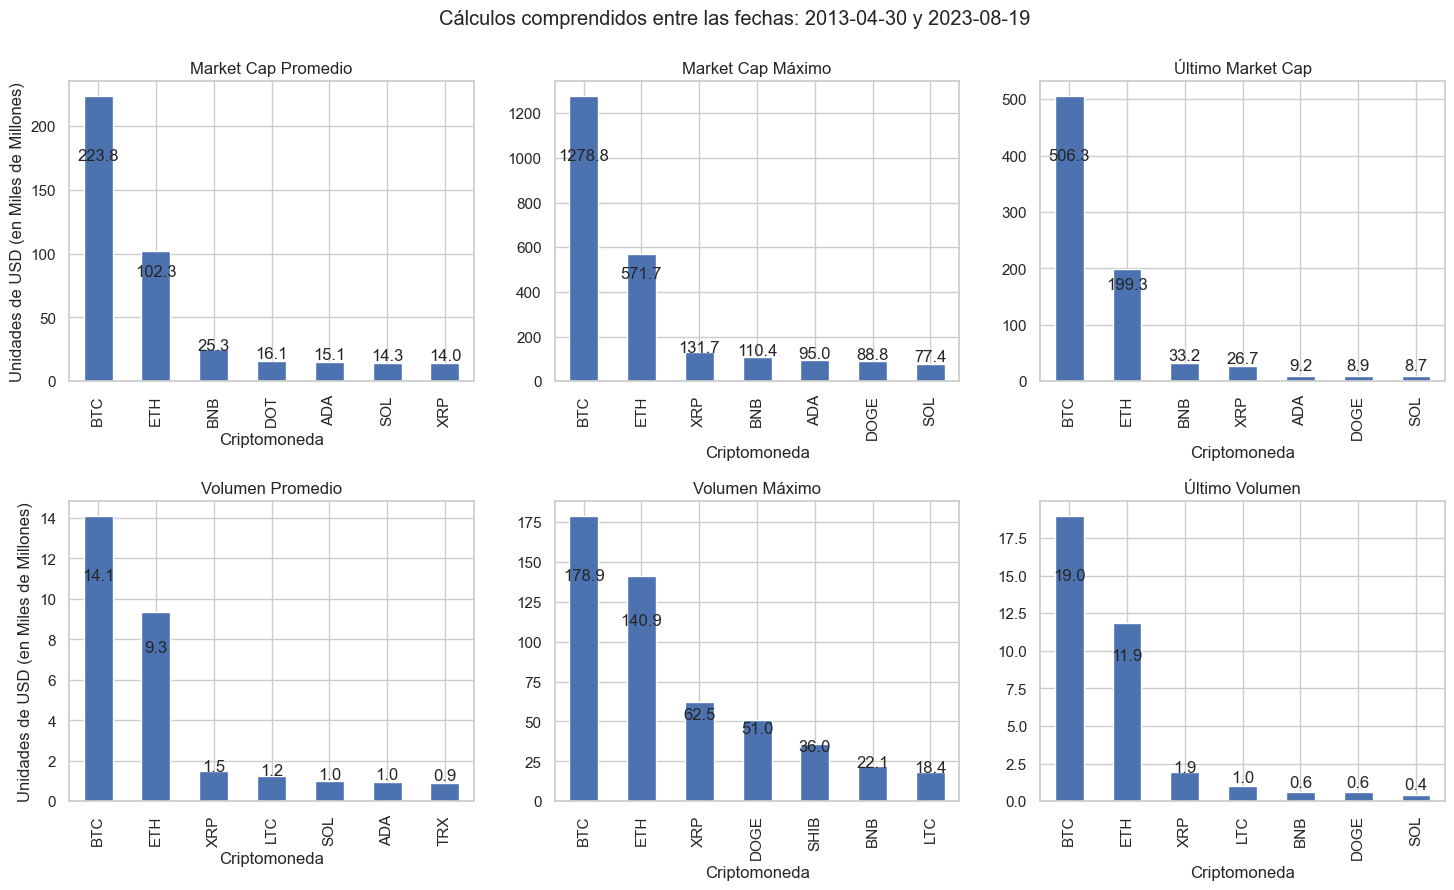

In [775]:
fig = plt.figure()
fig.suptitle(f'Cálculos comprendidos entre las fechas: {sd} y {ed}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

axes = []
for i in range(1,7):
    axes.append(fig.add_subplot(230+i))

sd = mc_df.sort_values(by='Fecha').reset_index(drop=True).Fecha[0].strftime('%Y-%m-%d')
ed = mc_df.sort_values(by='Fecha').reset_index(drop=True).Fecha[-1:].item().strftime('%Y-%m-%d')

axes[0].set_title(label=f'Market Cap Promedio'), axes[0].set_ylabel('Unidades de USD (en Miles de Millones)'), axes[1].set_title(label=f'Market Cap Máximo'), axes[2].set_title(label=f'Último Market Cap')
axes[3].set_title(label=f'Volumen Promedio'), axes[3].set_ylabel(ylabel='Unidades de USD (en Miles de Millones)'), axes[4].set_title(label=f'Volumen Máximo'), axes[5].set_title(label=f'Último Volumen')

mc_df['Market_Cap_mM'] = mc_df.Valor / 1000000000
usv_df['USD_Volumen_mM'] = usv_df.Valor / 1000000000

x = mc_df.groupby('Criptomoneda')['Market_Cap_mM']
x.mean().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[0]), x.max().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[1]), x.last().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[2])
y = usv_df.groupby('Criptomoneda')['USD_Volumen_mM']
y.mean().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[3]), y.max().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[4]), y.last().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[5])

for plano in axes:
    for rect in plano.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label.
        space = 3
        # Vertical alignment for positive values
        va = 'bottom'

        # Use Y value as label and format number with zero decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        plano.annotate(
            label,                      # Use `label` as label
            (x_value, y_value - (y_value/4)),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
plt.show()

# Gráficos de Barras de Precios.

### Primeras 6 Criptomonedas en Capitalización de Mercado después de BTC.

Para este caso vamos a descartar a BTC y a ETH debido a que sus precios están muy por arriba del precio de las demás criptos.

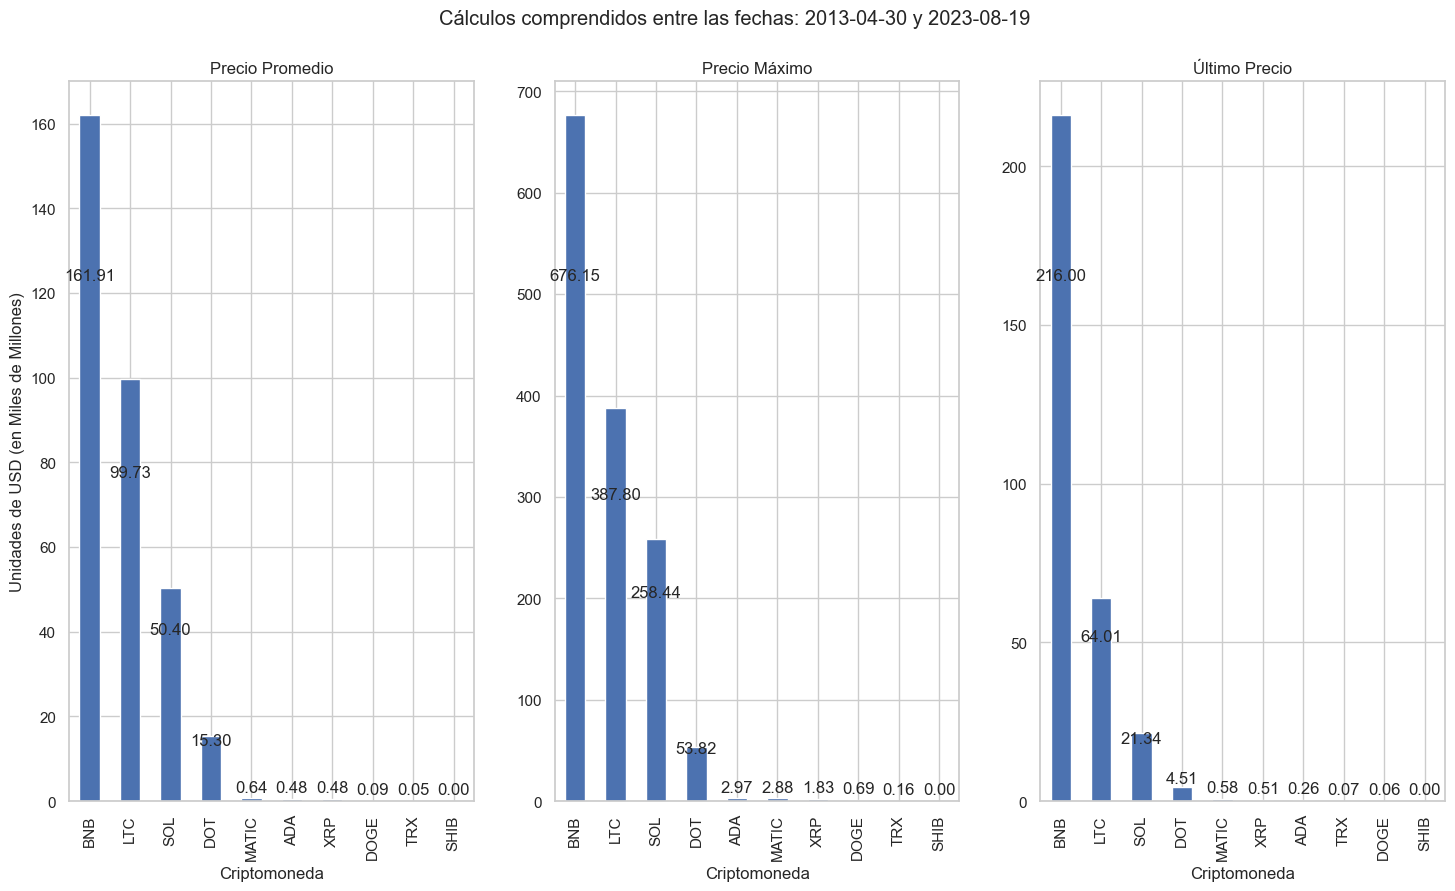

In [777]:
dfx = pd.melt(df_bn,id_vars='Fecha',value_vars=pre_str,var_name='Criptomoneda',value_name='Precio')

for i in sorted(coins):
    dfx['Criptomoneda'] = dfx['Criptomoneda'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)

# Ahora cambiamos de 'Tipo' a 'Cripto' puesto que ya tenemos los DF's separados por los 3 parámetros.
dfx = dfx.dropna().reset_index(drop=True)

fig = plt.figure()
fig.suptitle(f'Cálculos comprendidos entre las fechas: {sd} y {ed}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

axes = []
for i in range(1,4):
    axes.append(fig.add_subplot(130+i))
    
sd = dfx.sort_values(by='Fecha').reset_index(drop=True).Fecha[0].strftime('%Y-%m-%d')
ed = dfx.sort_values(by='Fecha').reset_index(drop=True).Fecha[-1:].item().strftime('%Y-%m-%d')

axes[0].set_title(label=f'Precio Promedio'), axes[0].set_ylabel('Unidades de USD (en Miles de Millones)'), axes[1].set_title(label=f'Precio Máximo'), axes[2].set_title(label=f'Último Precio')

x = dfx[(dfx.Criptomoneda != 'BTC') & (dfx.Criptomoneda != 'ETH')].groupby('Criptomoneda')['Precio']
x.mean().sort_values(ascending=False).plot(kind='bar',ax=axes[0]), x.max().sort_values(ascending=False).plot(kind='bar',ax=axes[1]), x.last().sort_values(ascending=False).plot(kind='bar',ax=axes[2])

for plano in axes:
    for rect in plano.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label.
        space = 3
        # Vertical alignment for positive values
        va = 'bottom'

        # Use Y value as label and format number with zero decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        plano.annotate(
            label,                      # Use `label` as label
            (x_value, y_value - (y_value/4)),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
                                        
plt.show()

### Conclusión sobre los gráficos anteriores.

Con la información anterior, podemos observar que las mejores criptos después de BTC son: ETH, XRP, BNB y ADA. En ese orden de importancia. Siendo XRP la tercer mejor criptomoneda debido a los números anteriores y su fundamental de cero comisiones por transacción. Con respecto a su fundamental, tiene sentido que sea la tercer moneda con más volumen de transacciones, después de BTC y ETH, a pesar de su baja volatilidad con respecto a estas dos primeras. Esto confirma que  el volumen de las dos primeras se explique por la alta demanda de trading de los usuarios sobre estas criptos, mientras que XRP se utiliza principalmente como agente de traslado de valor entre intercambios debido a su nula comisión.

Debido a esto, una estrategia de inversión es la de mantener los fondos en stablecoins y, una vez que se desee mover el dinero, utilizar XRP para hacer dicho movimiento. Además, para quienes desean realizar trading, deben saber que la mayor volatilidad se ve en BTC y ETH. Sin ser esta una recomendación de inversión ni nada parecido.

### Propuestas de análisis

A considerar propongo los siguientes puntos:

        * Se puede establecer un indicador que tome en cuenta el market cap máximo y el último con respecto a su promedio. Quizá puedan ser dos indicadores los que podamos obtener de aquí, uno con respecto al máximo y el promedio y otro con respecto al último y el promedio. Además, esto se puede combinar con las fechas respectivas del último y del máximo junto con la fecha del próximo o del anterior halving.

        * Es evidente que también hay que considerar estos parámetros en el precio, con respecto a la fecha de los halvings, anterior y próximo, de BTC y el precio de ese momento.

        * Además, se pretende agregar datos de inflación y tasas de interés en EE.UU.

        * Se pueden agregar medias móviles al EDA como validadores de tendencia.

Estos puntos se deben/pueden aplicar a todas las criptomonedas que tenemos actualmente.

# =========================================================
# Gráficos Históricos de Volumen, Market Cap y Precios

Ahora vamos a visualizar datos históricos mediante gráficos de líneas con sus promedios generales.

##### Gráficos de Market Cap:

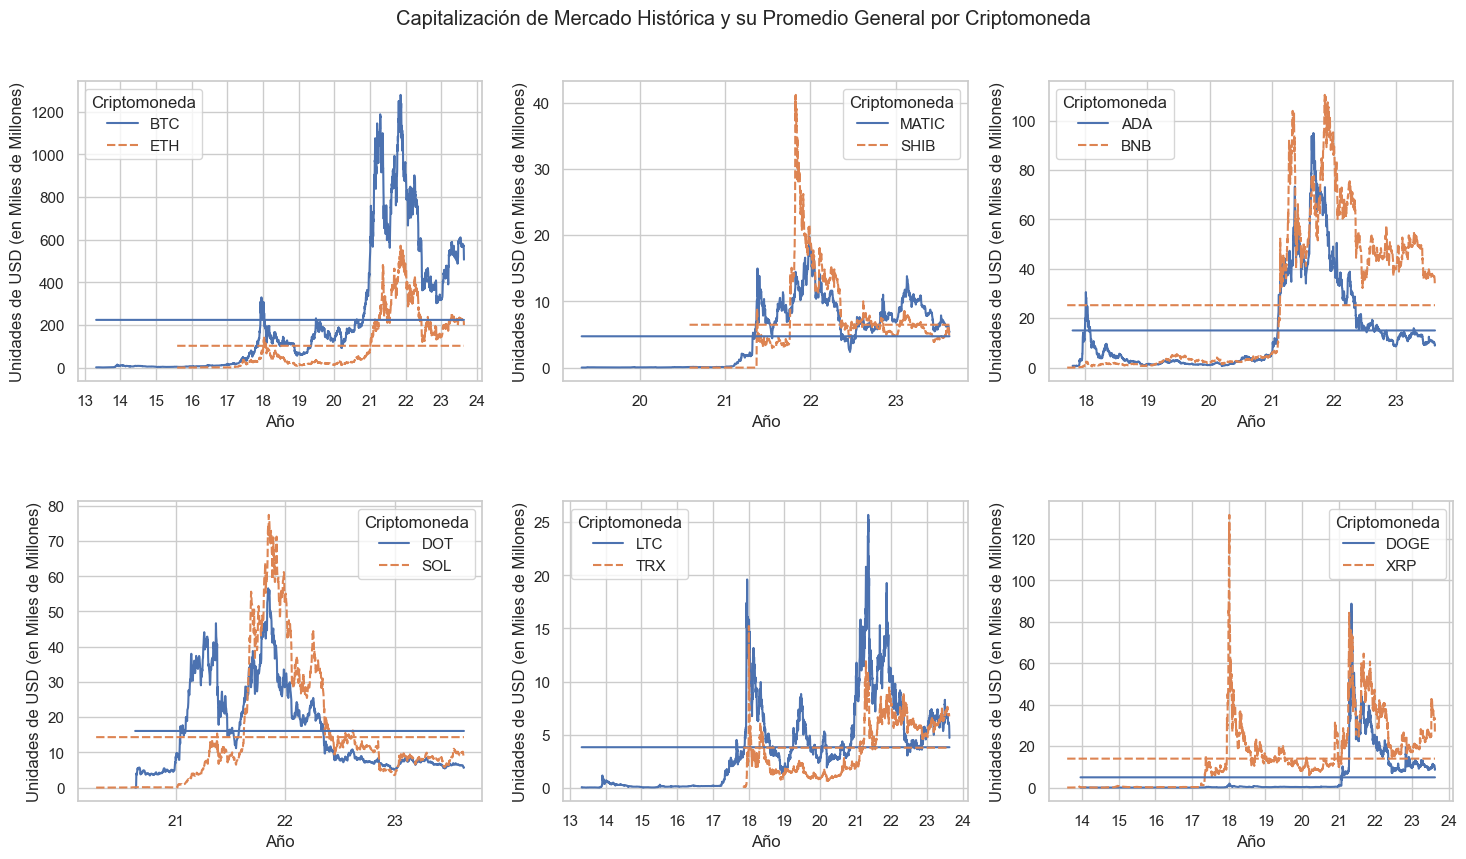

In [780]:
fig = plt.figure()
fig.suptitle('Capitalización de Mercado Histórica y su Promedio General por Criptomoneda')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

lista = []
for i in range(1,7):
    lista.append(fig.add_subplot(230+i))

for ax in lista:
    ax.xaxis.set_major_locator(YearLocator(1, month=1, day=1))
    ax.xaxis.set_major_formatter(DateFormatter('%y'))
    ax.set_ylabel('Unidades de USD (en Miles de Millones)')
    ax.set_xlabel(xlabel='Año')

mc_df['Market_Cap_mM'] = mc_df.Valor / 1000000000

mc_fisix = mc_df.merge(mc_df.groupby('Criptomoneda')['Market_Cap_mM'].mean(), on='Criptomoneda').rename(columns={ 'Market_Cap_mM_x': 'Market_Cap_mM', 'Market_Cap_mM_y':'Promedio'})

j = 0
for i in [['ETH','BTC'],['MATIC','SHIB'],['BNB','ADA'],['DOT','SOL'],['LTC','TRX'],['XRP','DOGE']]:
    sns.lineplot(mc_fisix[mc_fisix.Criptomoneda.isin(i)].groupby(['Fecha','Criptomoneda'])['Market_Cap_mM'].last().unstack(),ax=lista[j])
    sns.lineplot(mc_fisix[mc_fisix.Criptomoneda.isin(i)].groupby(['Fecha','Criptomoneda'])['Promedio'].last().unstack(),ax=lista[j],legend=False)
    j += 1
plt.show()

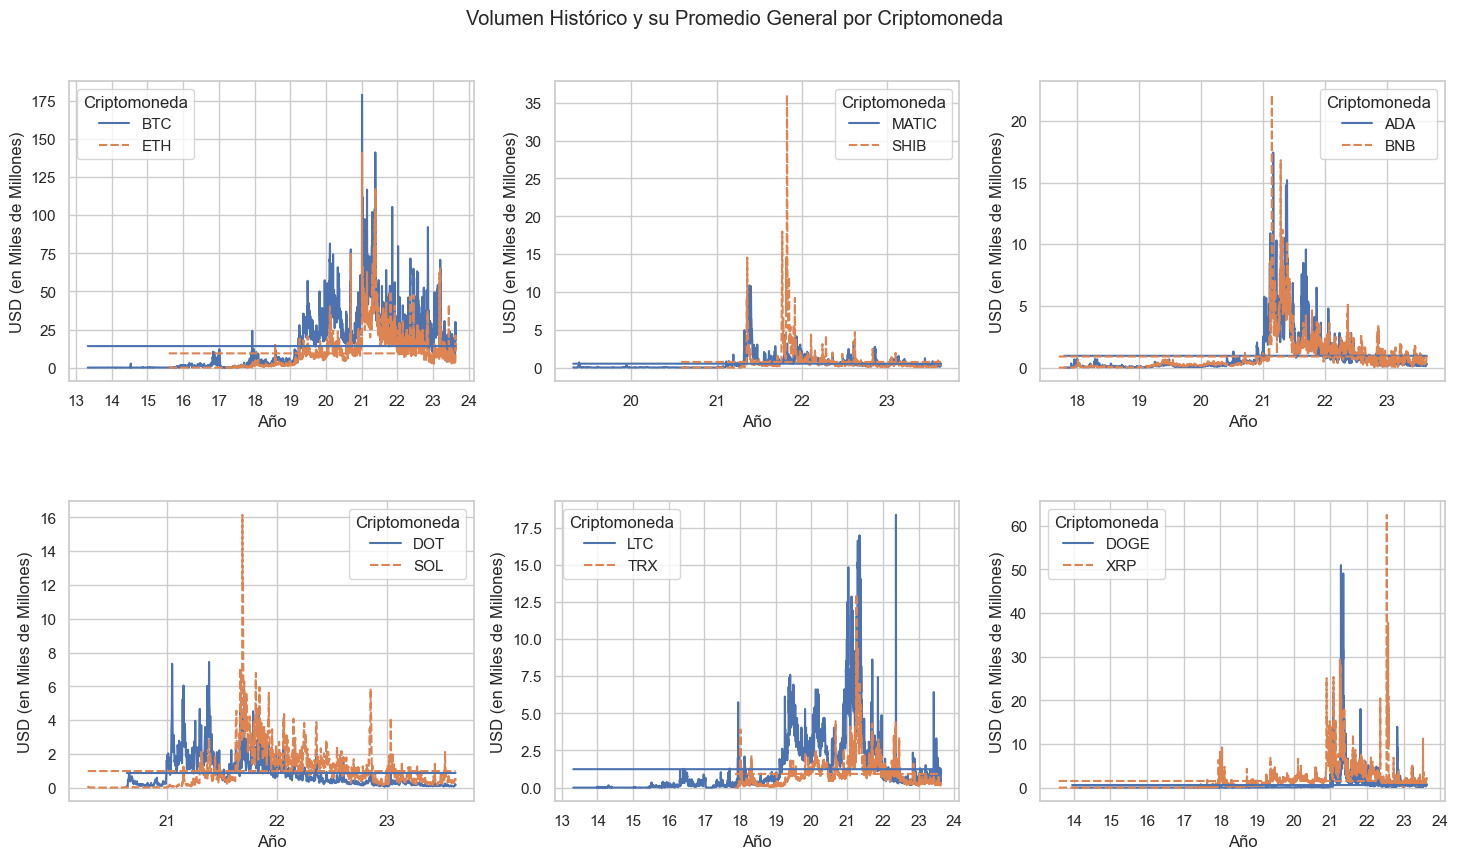

In [781]:

fig = plt.figure()
fig.suptitle('Volumen Histórico y su Promedio General por Criptomoneda')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

lista = []
for i in range(1,7):
    lista.append(fig.add_subplot(230+i))

for ax in lista:
    ax.xaxis.set_major_locator(YearLocator(1, month=1, day=1))
    ax.xaxis.set_major_formatter(DateFormatter('%y'))
    ax.set_ylabel('USD (en Miles de Millones)')
    ax.set_xlabel(xlabel='Año')

usv_df['Market_Cap_mM'] = usv_df.Valor / 1000000000

usv_fisix = usv_df.merge(usv_df.groupby('Criptomoneda')['USD_Volumen_mM'].mean(), on='Criptomoneda').rename(columns={ 'USD_Volumen_mM_x': 'USD_Volumen_mM', 'USD_Volumen_mM_y':'Promedio'})

j = 0
for i in [['ETH','BTC'],['MATIC','SHIB'],['BNB','ADA'],['DOT','SOL'],['LTC','TRX'],['XRP','DOGE']]:
    sns.lineplot(usv_fisix[usv_fisix.Criptomoneda.isin(i)].groupby(['Fecha','Criptomoneda'])['USD_Volumen_mM'].last().unstack(),ax=lista[j])
    sns.lineplot(usv_fisix[usv_fisix.Criptomoneda.isin(i)].groupby(['Fecha','Criptomoneda'])['Promedio'].last().unstack(),ax=lista[j],legend=False)
    j += 1
plt.show()

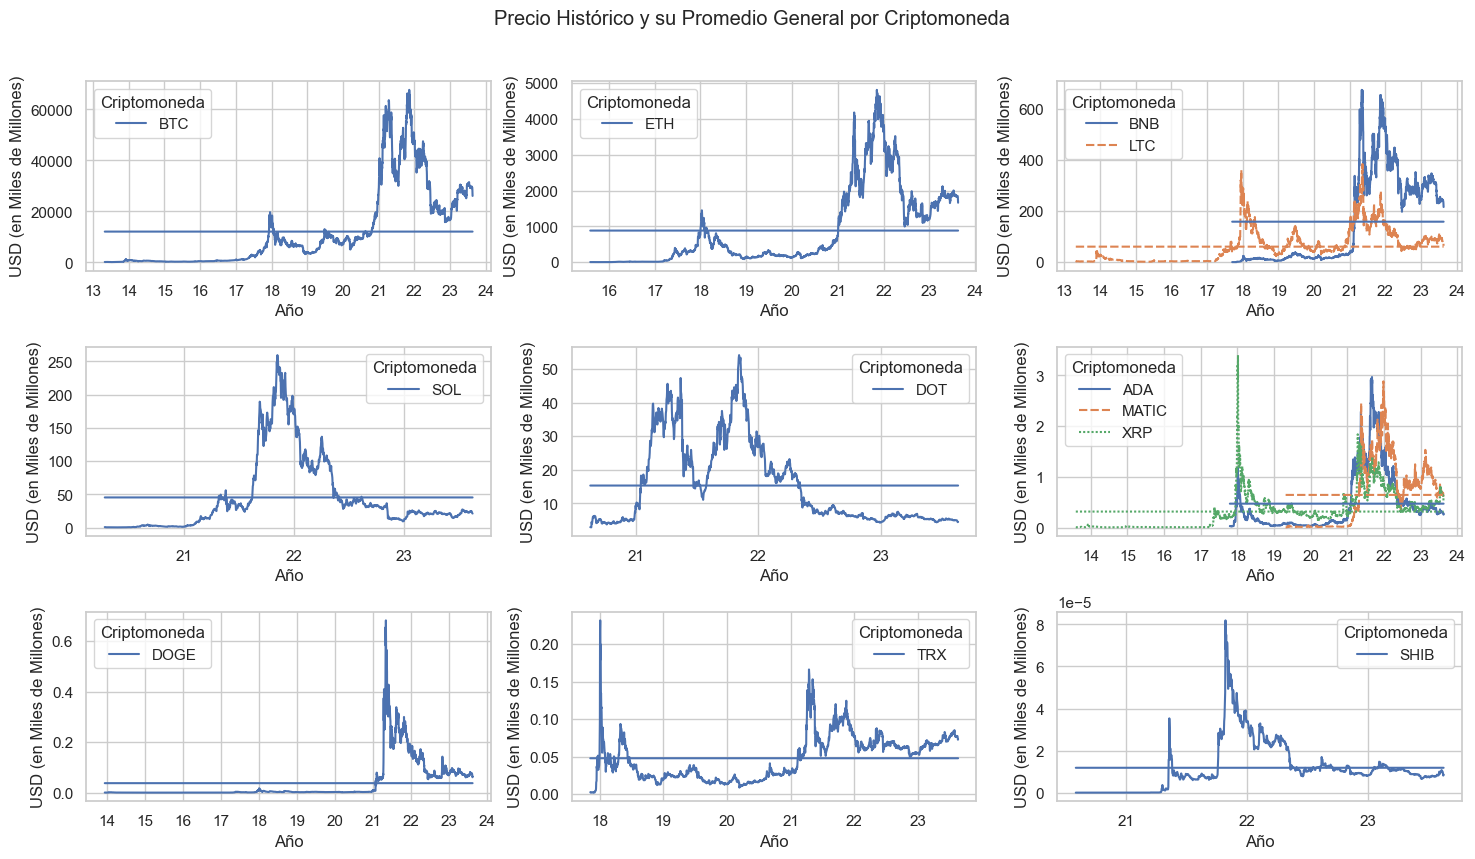

In [792]:
fig = plt.figure()
fig.suptitle('Precio Histórico y su Promedio General por Criptomoneda')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

lista = []
for i in range(1,10):
    lista.append(fig.add_subplot(3,3,i))
    
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = lista

for ax in lista:
    ax.xaxis.set_major_locator(YearLocator(1, month=1, day=1))
    ax.xaxis.set_major_formatter(DateFormatter('%y'))
    ax.set_ylabel('USD (en Miles de Millones)')
    ax.set_xlabel(xlabel='Año')
    
j = 0    
for i in dfc:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i[f'{coins[j]}_Volumen'] = i.Volumen / i.Precios
    i = i[['Fecha','Precios']]
    i.columns = ['Fecha',f'{crl[j].upper()}']
    
    if j == 0:
        df_cgp = i
    else:
        df_cgp = df_cgp.merge(i,how='left',on='Fecha')
    j += 1
    
dfp = pd.melt(df_cgp,id_vars='Fecha',value_vars=df_cgp.columns.to_list().remove('Fecha'),var_name='Criptomoneda',value_name='Precio') 
dfp = dfp.merge(dfp.groupby('Criptomoneda')['Precio'].mean(), on='Criptomoneda').rename(columns={ 'Precio_x': 'Precio', 'Precio_y':'Promedio'})
dfp = dfp.dropna().reset_index(drop=True)

j = 0
for i in [['BTC'],['ETH'],['BNB','LTC'],['SOL'],['DOT'],['ADA','XRP','MATIC'],['DOGE'],['TRX'],['SHIB']]:
    sns.lineplot(dfp[dfp.Criptomoneda.isin(i)].groupby(['Fecha','Criptomoneda'])['Precio'].last().unstack(),ax=lista[j])
    sns.lineplot(dfp[dfp.Criptomoneda.isin(i)].groupby(['Fecha','Criptomoneda'])['Promedio'].last().unstack(),ax=lista[j],legend=False)
    j += 1
plt.show()

### Conclusión de las Gráficas sobre los Históricos del Precio, del Volumen y del Market Cap

De los tres datos que utilizamos, creo que no puedo decir nada al respecto del volumen, ya que tiene un patron más inestable y no noté nada en dichas gráficas.

Sin embargo, en las gráficas de precios y de Market Cap, se puede observar una mayor estabilidad y además se percibe un patron entre las criptomonedas: Aquellas que están por arriba de su promedio después del halving anterior y aún después del respectivo bear market posterior al halving, y aquellas que están por debajo.

Las conclusiones son:

        * Podemos considerar una criptomoneda que se mantiene por arriba de su promedio, ya sea en market cap o en precio, como una cripto más saludable o segura que aquella que está por debajo de su promedio.

        * El mismo hecho también se puede entender como un riesgo moderado de que el precio caiga antes del siguiente halving, o incluso como una oportunidad de mayor ganancia que en otras criptos.

### Propuestas de análisis

        * La primera conclusión debe complementarse con un análisis fundamental del proyecto, principalmente.

        * De la segunda conclusión, tanto el riesgo como la oportunidad, podrían entenderse mejor con un análisis sobre la relación entre los promedios de cada cripto en periodos de tiempo relacionados con los halvings pasados y el próximo.

# =========================================================
# Autocorrelación de los datos de Precios, Volumen y Market Cap

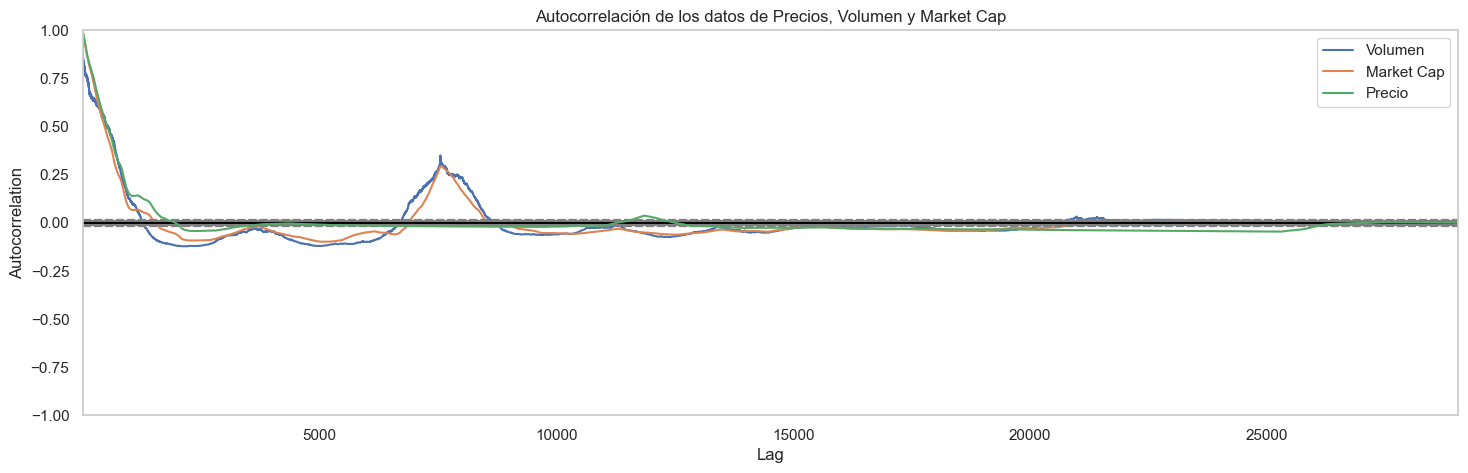

In [660]:
plt.figure(figsize=(17.75,5))
plt.title('Autocorrelación de los datos de Precios, Volumen y Market Cap')
pd.plotting.autocorrelation_plot(usv_df.USD_Volumen_mM,label='Volumen') # Es más rápido que plt.acorr()
pd.plotting.autocorrelation_plot(mc_df.Market_Cap_mM,label='Market Cap')
pd.plotting.autocorrelation_plot(dfp.Precio,label='Precio')
plt.show()

### Qué significa la autocorrelación?

Básicamente es una medida de la aleatoriedad de la serie. En este sentido, si la línea está por fuera del umbral, significa que no es una serie de datos aleatoria.

Como vemos, ninguno de los datos es aleatorio en este sentido.

Vemos que de alguna manera, la autocorrelación del volumen y del market cap se comportan de manera similar. Quizá esto signifique algo en especial.

# =========================================================

# Histogramas del Precio, el Volumen y el Market Cap.

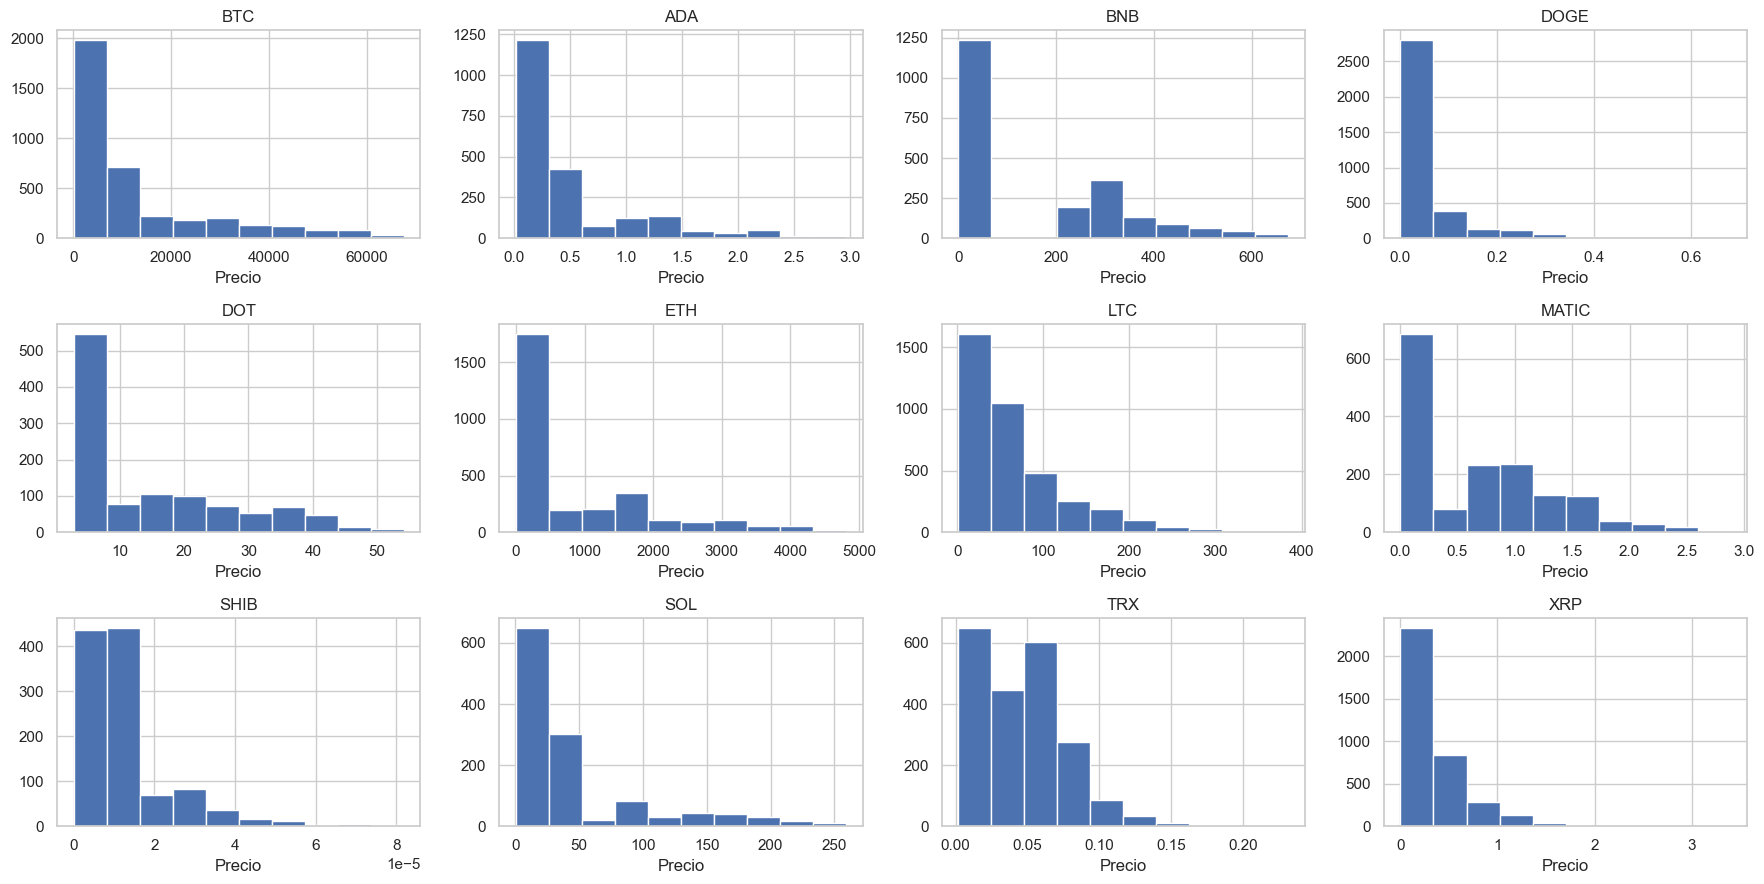

In [685]:
fig, axes = plt.subplots(nrows=3, ncols=4)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flatten()
lista = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]

j = 0
for i in coins:
    lista[j].hist(dfp[dfp.Criptomoneda == i.upper()].Precio,label=i.upper())
    lista[j].set_title(i.upper())
    lista[j].set_xlabel(xlabel='Precio')
    j += 1
fig.tight_layout()
plt.show()

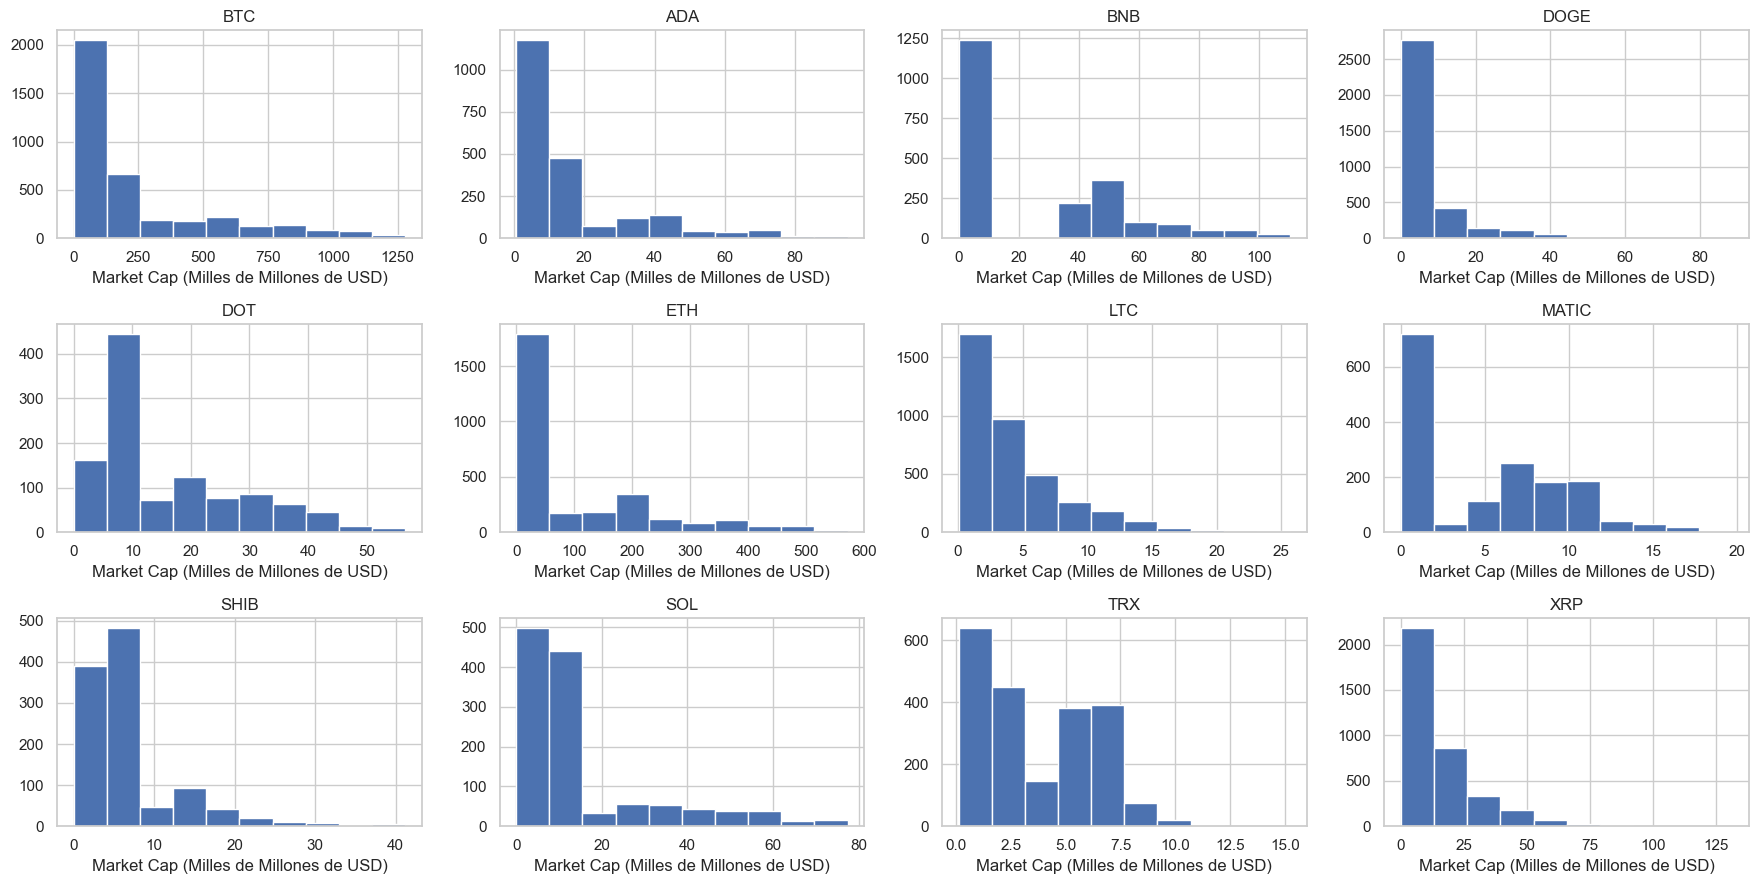

In [689]:
fig, axes = plt.subplots(nrows=3, ncols=4)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flatten()
lista = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]

j = 0
for i in coins:
    lista[j].hist(mc_df[mc_df.Criptomoneda == i.upper()].Market_Cap_mM,label=i.upper())
    lista[j].set_title(i.upper())
    lista[j].set_xlabel(xlabel='Market Cap (Milles de Millones de USD)')
    j += 1
fig.tight_layout()
plt.show()

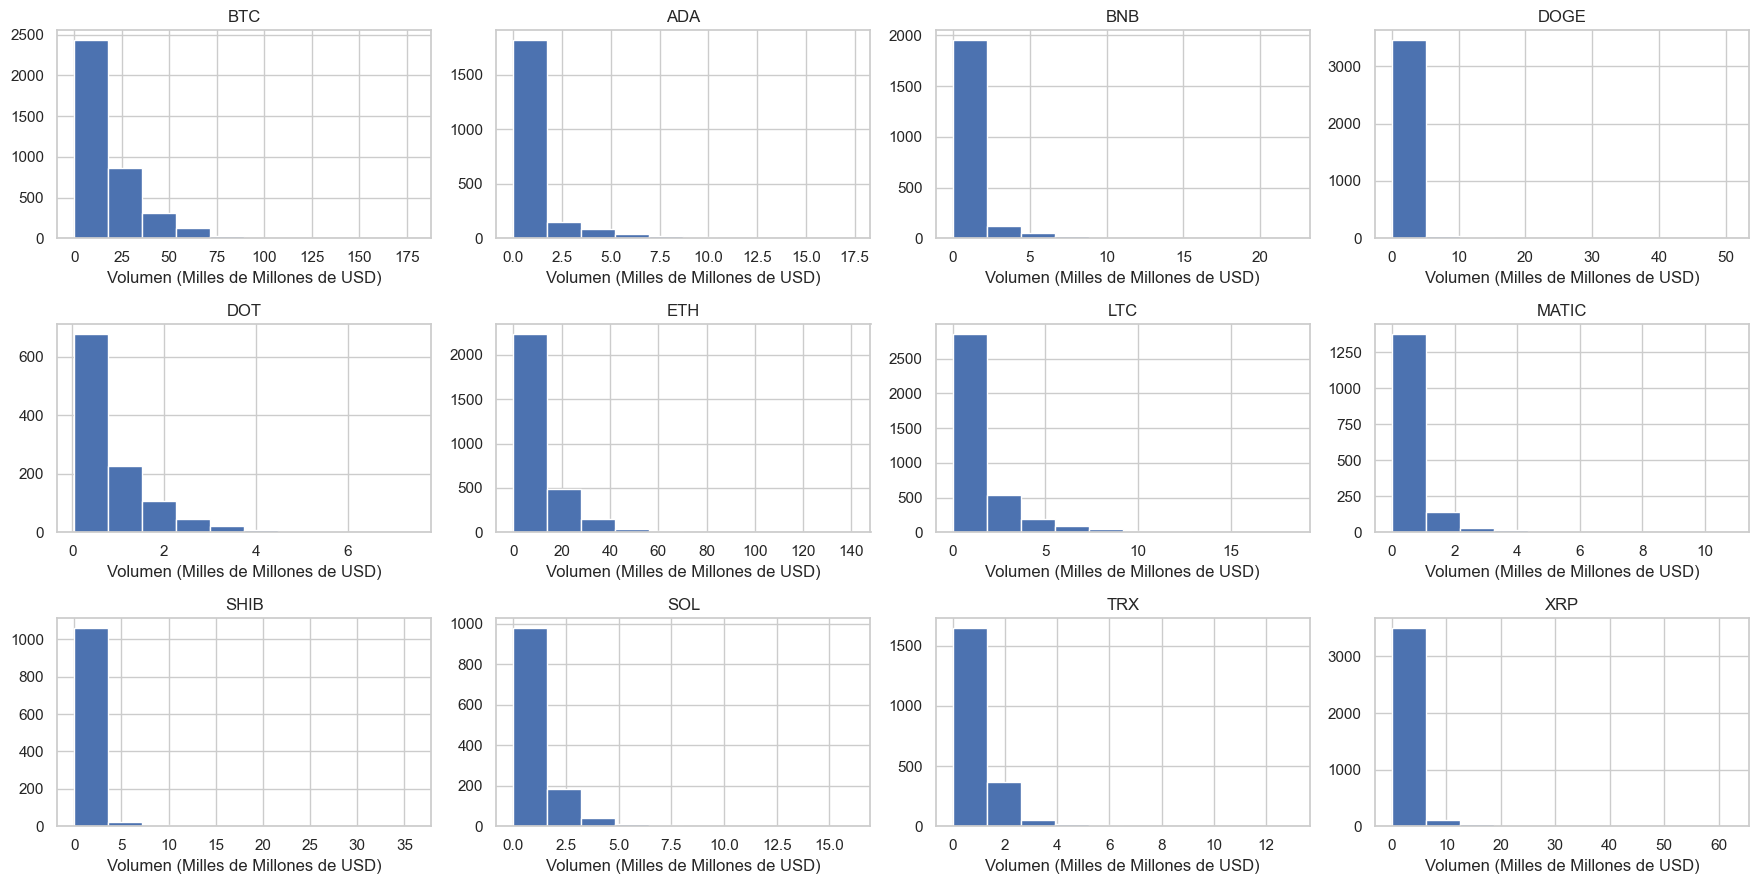

In [688]:
fig, axes = plt.subplots(nrows=3, ncols=4)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flatten()
lista = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]

j = 0
for i in coins:
    lista[j].hist(usv_df[usv_df.Criptomoneda == i.upper()].USD_Volumen_mM,label=i.upper())
    lista[j].set_title(i.upper())
    lista[j].set_xlabel(xlabel='Volumen (Milles de Millones de USD)')
    j += 1
fig.tight_layout()
plt.show()

### Conclusión sobre los histogramas.

Podemos ver claramente que los resultados más diversos los encontramos en el market cap, después en el precio y por último en el volumen. Esto quiere decir que se encuentran más acotados los datos de volumen y de precio que los de market cap, esto se puede explicar debido a que el market cap está sujeto a la variación no solo del precio, sino también a la variación del suministro del criptoactivo. 

También vemos que todos los datos se han mantenido mayoritariamente en los valores más bajos. Esto nos lleva a concluir que, en la perspectiva del largo plazo y con los datos actuales, el mercado cripto no es un mercado consolidado y puede ser que en cualquier momento los precios retrocedan de manera considerable a sus inicios. Sin embargo, es una visión sesgada, también en la perspectiva de largo plazo, puesto que no hay suficientes datos, como por ejemplo sí los hay para la bolsa de valores de NY, con sus más de 200 años, o para compañías privadas modernas con más tiempo que las criptomonedas.

Este problema solo se va a aclarar con el tiempo, el resultado dependerá de la adopción de este mercado en la sociedad y las regulaciones que sean creadas por los gobiernos en torno a dicho mercado.

# =========================================================

# Regresando a los DF's iniciales: df_cg y df_bn.

Ahora vamos a hacer uso de los DF's iniciales, con los cuales vamos a generar correlaciones entre las columnas.

In [794]:
df_bn = df_bn[['Fecha'] + op_str_bn + hi_str_bn + lo_str_bn + pre_str_bn + usv_str_bn + crv_str_bn]
df_cg = df_cg[['Fecha'] + mc_str_cg + pre_str_cg + usv_str_cg + crv_str_cg]
df_cg.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

In [817]:
df_bn.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

### Matrices de Correlación.

Si bien es imposible leer a profundidad las matrices debido a la gran cantidad de columnas que tienen, sí nos es de utilidad puesto que podemos ver que existen muchas variables que se correlacionan razonablemente.

Para poder lograr obtener las mejores correlaciones y sus variables, vamos a continuar con la siguiente celda, en la cual vamos a desarrollar gráficas de correlación de los datos de binance. Posteriormente seguiremos con los datos de coingecko.

### Datos de Binance:

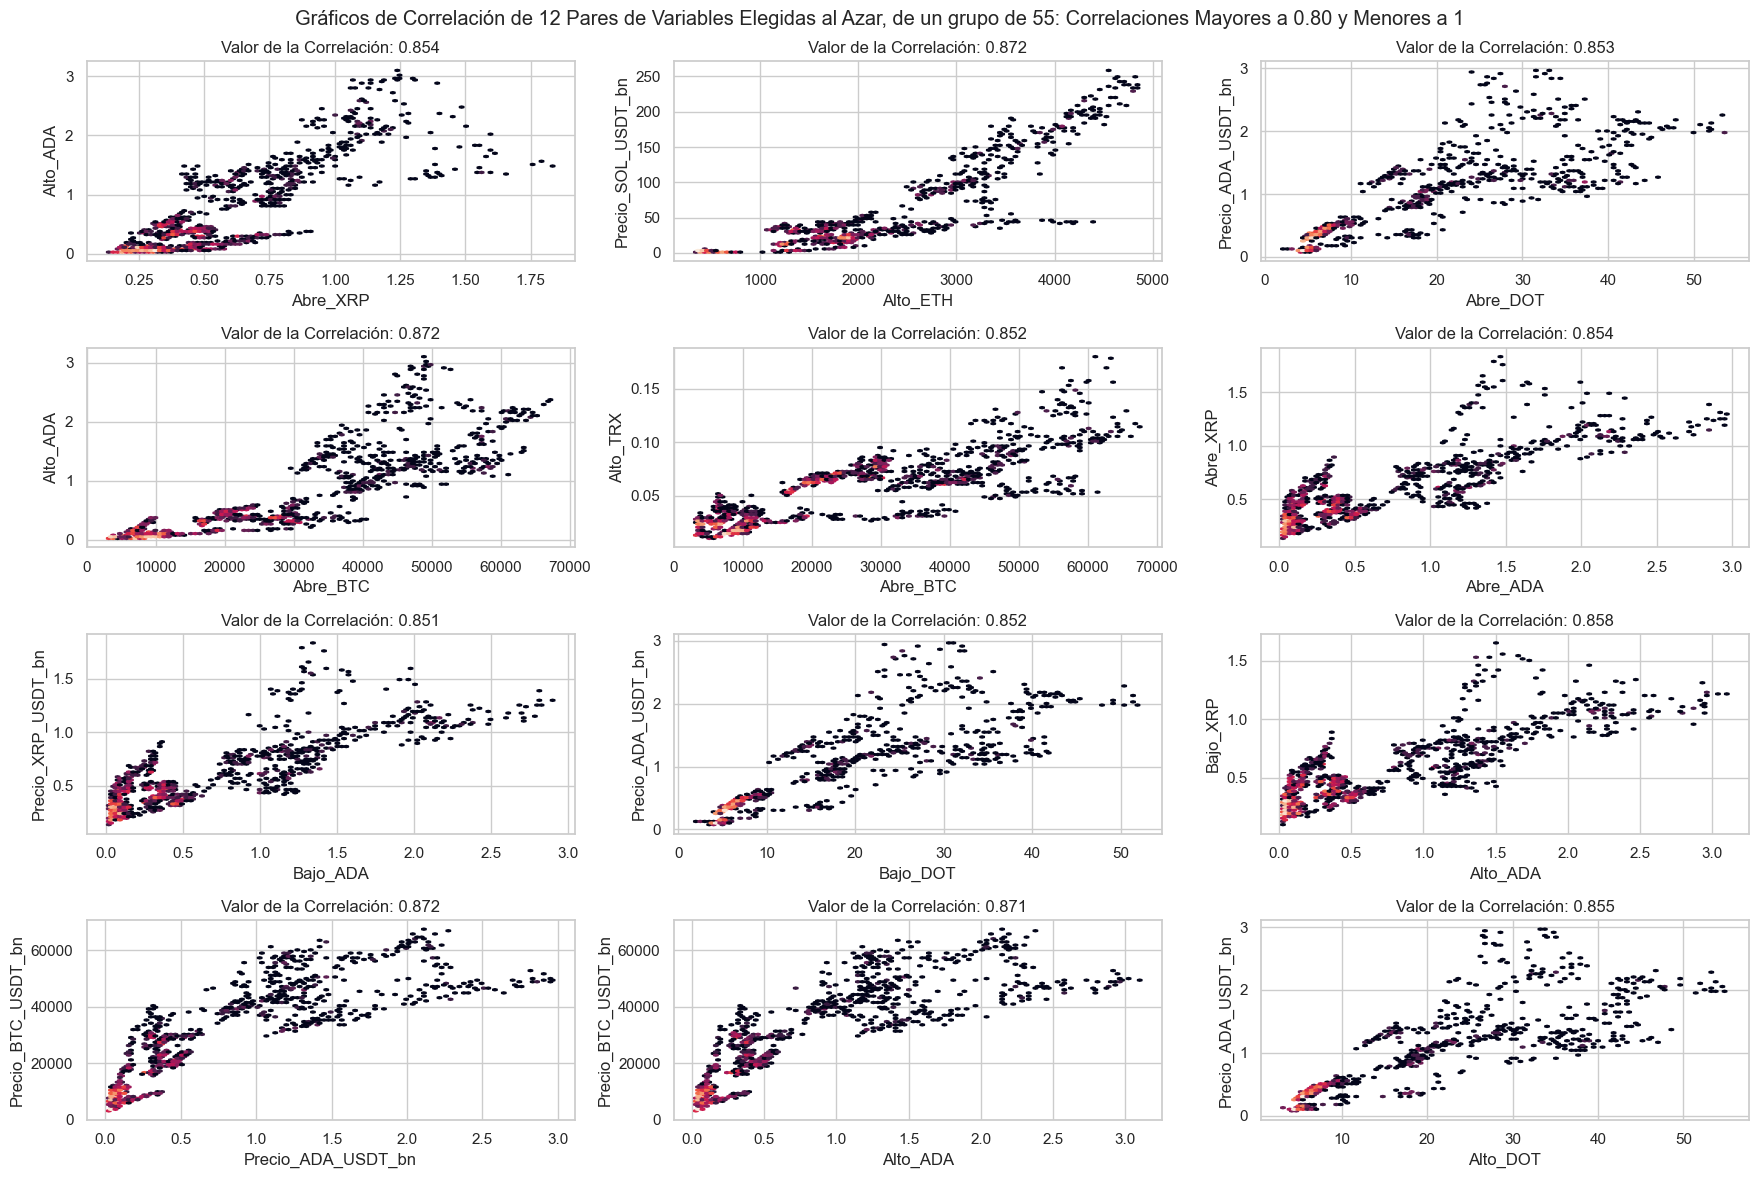

In [1243]:
corr_df_bn = pd.DataFrame(df_bn.corr(numeric_only=False).unstack()).reset_index()

corr_df_bn.columns = ['Var1','Var2','Correlacion']
corr_df_bn = corr_df_bn.sort_values(by=['Correlacion','Var1'])[::2].reset_index(drop=True)
corr_df_bn_copy = corr_df_bn
corr_df_bn = corr_df_bn[(corr_df_bn.Correlacion < 1) & (abs(corr_df_bn.Correlacion) > 0.85)]

var1_mask = []; var2_mask = []; masks = []; j = 0
for i in coins:
    var1_mask.append((corr_df_bn.Var1.str.contains(f'Alto_{i.upper()}')) | (corr_df_bn.Var1.str.contains(f'Abre_{i.upper()}')) | (corr_df_bn.Var1.str.contains(f'Precio_{i.upper()}')) | (corr_df_bn.Var1.str.contains(f'Bajo_{i.upper()}')))
    var2_mask.append((corr_df_bn.Var2.str.contains(f'Alto_{i.upper()}')) | (corr_df_bn.Var2.str.contains(f'Abre_{i.upper()}')) | (corr_df_bn.Var2.str.contains(f'Precio_{i.upper()}')) | (corr_df_bn.Var2.str.contains(f'Bajo_{i.upper()}')))
    masks.append(var1_mask[j] & var2_mask[j])
    j += 1

indices = []
for i in masks:
    indices.append(corr_df_bn[i].index.to_list())
btcbnb = (var1_mask[0] & var2_mask[2]) | (var1_mask[2] & var2_mask[0])
bnbeth = (var1_mask[2] & var2_mask[5]) | (var1_mask[5] & var2_mask[2])
btceth = (var1_mask[5] & var2_mask[0]) | (var1_mask[0] & var2_mask[5])
indices.append(corr_df_bn[bnbeth | btcbnb | btceth].index.to_list())
index_val = []
for i in indices:
    for j in i:
        index_val.append(j)

corr_df_bn = corr_df_bn.drop(index_val).reset_index(drop=True)

index_val = random.sample(list(range(55)),15)

fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(17.75,12))
fig.suptitle('Gráficos de Correlación de 12 Pares de Variables Elegidas al Azar, de un grupo de 55: Correlaciones Mayores a 0.80 y Menores a 1')
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flatten()
lista = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]# for i in range(9):

for i in range(12):
    lista[i].hexbin(x=df_bn[f'{corr_df_bn.Var1[index_val[i]]}'],y=df_bn[f'{corr_df_bn.Var2[index_val[i]]}'],bins='log')
    lista[i].set_title(f'Valor de la Correlación: {round(corr_df_bn.Correlacion[index_val[i]],3)}')
    lista[i].set_xlabel(xlabel=f'{corr_df_bn.Var1[index_val[i]]}')
    lista[i].set_ylabel(ylabel=f'{corr_df_bn.Var2[index_val[i]]}')

plt.tight_layout()
plt.show()

### Datos de CoinGecko:

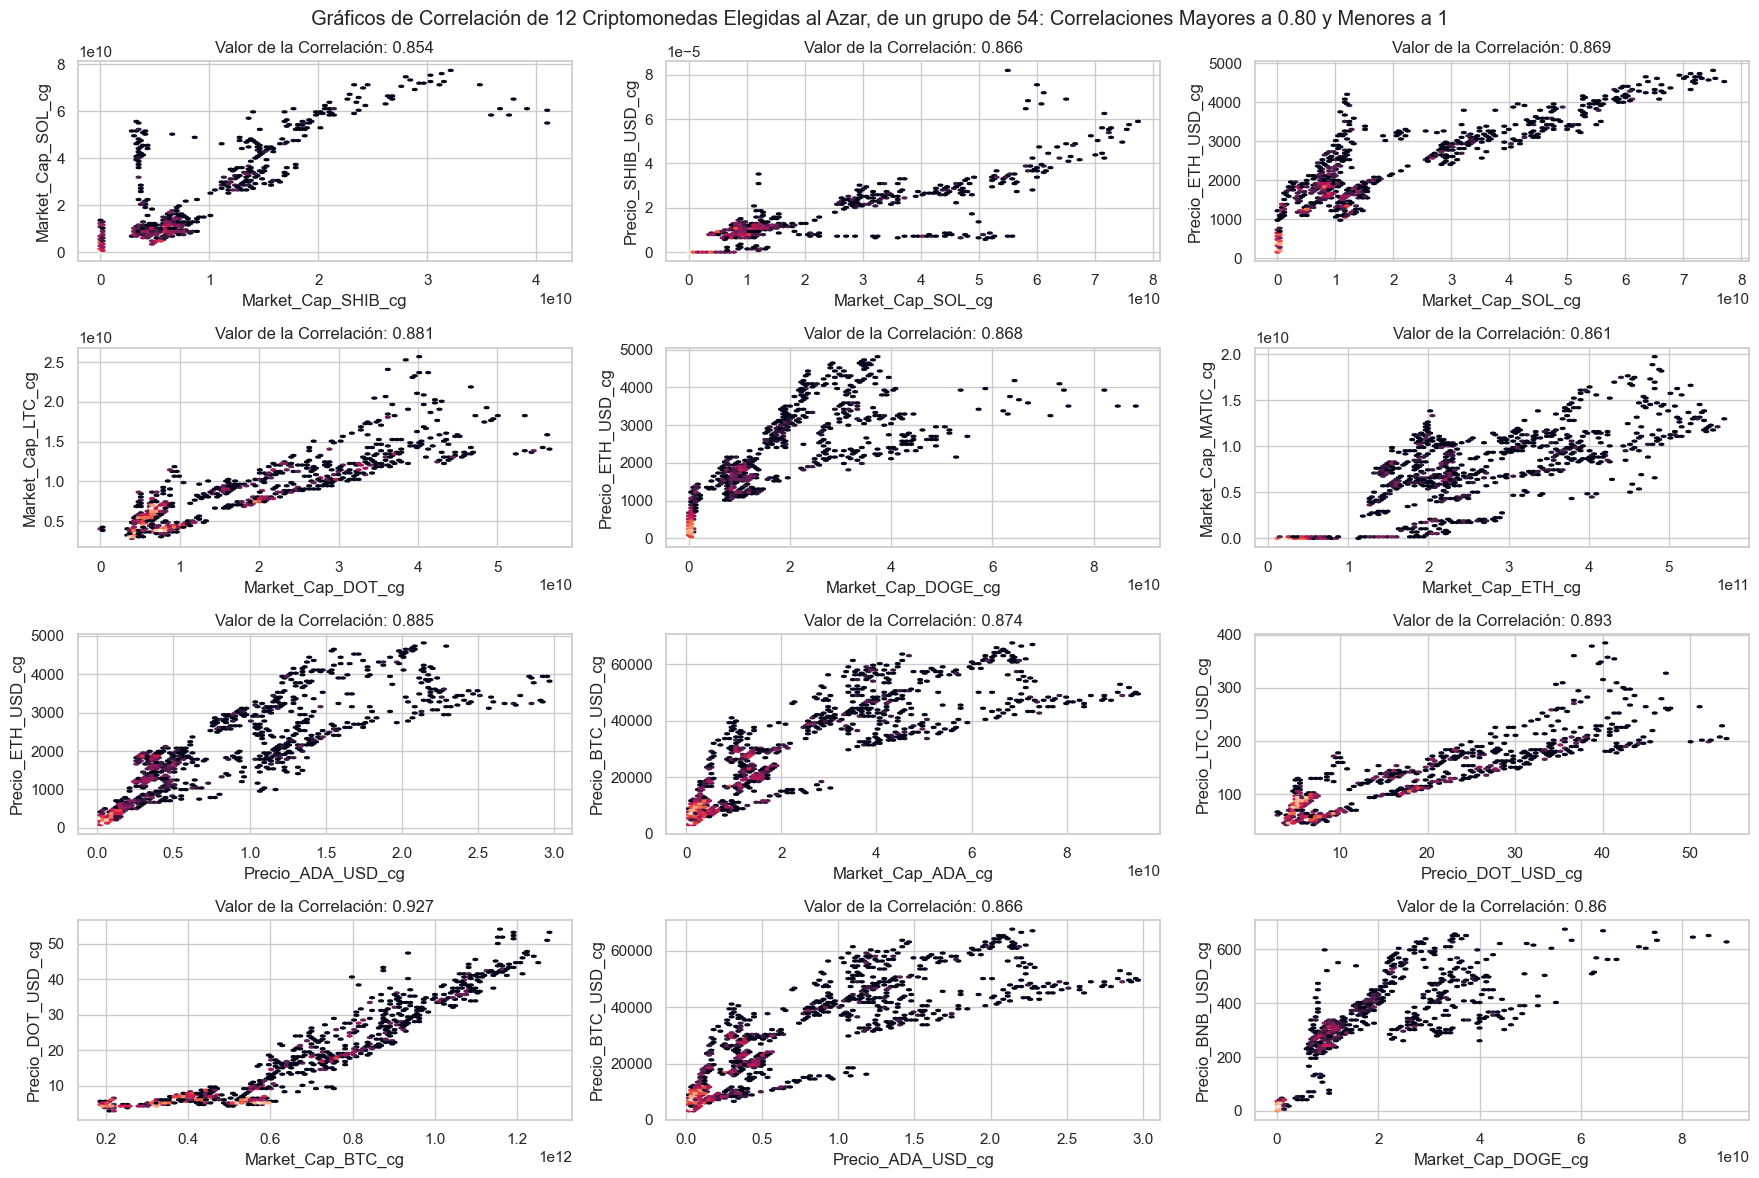

In [1244]:
corr_df_cg = pd.DataFrame(df_cg.corr(numeric_only=False).unstack()).reset_index()

corr_df_cg.columns = ['Var1','Var2','Correlacion']
corr_df_cg = corr_df_cg.sort_values(by=['Correlacion','Var1'])[::2].reset_index(drop=True)
corr_df_cg_copy = corr_df_cg
corr_df_cg = corr_df_cg[(corr_df_cg.Correlacion < 1) & (abs(corr_df_cg.Correlacion) > 0.85)]

var1_mask = []; var2_mask = []; masks = []; j = 0
for i in coins:
    var1_mask.append((corr_df_cg.Var1.str.contains(f'Cap_{i.upper()}')) | (corr_df_cg.Var1.str.contains(f'Volumen_{i.upper()}')) | (corr_df_cg.Var1.str.contains(f'Precio_{i.upper()}')) | (corr_df_cg.Var1.str.contains(f'{i.upper()}_Volumen')))
    var2_mask.append((corr_df_cg.Var2.str.contains(f'Cap_{i.upper()}')) | (corr_df_cg.Var2.str.contains(f'Volumen_{i.upper()}')) | (corr_df_cg.Var2.str.contains(f'Precio_{i.upper()}')) | (corr_df_cg.Var2.str.contains(f'{i.upper()}_Volumen')))
    masks.append(var1_mask[j] & var2_mask[j])
    j += 1

indices = []
for i in masks:
    indices.append(corr_df_cg[i].index.to_list())
btcbnb = (var1_mask[0] & var2_mask[2]) | (var1_mask[2] & var2_mask[0])
bnbeth = (var1_mask[2] & var2_mask[5]) | (var1_mask[5] & var2_mask[2])
btceth = (var1_mask[5] & var2_mask[0]) | (var1_mask[0] & var2_mask[5])
indices.append(corr_df_cg[bnbeth | btcbnb | btceth].index.to_list())
index_val = []
for i in indices:
    for j in i:
        index_val.append(j)

corr_df_cg = corr_df_cg.drop(index_val).reset_index(drop=True)

index_val = random.sample(list(range(55)),12)

fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(17.75,12)); fig.suptitle('Gráficos de Correlación de 12 Criptomonedas Elegidas al Azar, de un grupo de 54: Correlaciones Mayores a 0.80 y Menores a 1')
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flatten(); lista = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]

for i in range(12):
    lista[i].hexbin(x=df_cg[f'{corr_df_cg.Var1[index_val[i]]}'],y=df_cg[f'{corr_df_cg.Var2[index_val[i]]}'],bins='log')
    lista[i].set_title(f'Valor de la Correlación: {round(corr_df_cg.Correlacion[index_val[i]],3)}')
    lista[i].set_xlabel(xlabel=f'{corr_df_cg.Var1[index_val[i]]}')
    lista[i].set_ylabel(ylabel=f'{corr_df_cg.Var2[index_val[i]]}')

plt.tight_layout()
plt.show()

In [1138]:
corr_df_bn.shape,corr_df_cg.shape,df_bn.shape,df_cg.shape, 72**2, 48**2, 120**2, 72**2 + 48**2, 120**2 - (72**2 + 48**2), 72*48*2

((55, 3), (54, 3), (2193, 73), (3763, 49), 5184, 2304, 14400, 7488, 6912, 6912)

### Sobre las correlaciones.

Lo que trabajamos en las celdas anteriores fue una correlación lineal. De todo el trabajo hecho, observamos que existen muchas variables altamente correlacionadas entre sí. Sin embargo, en las dos celdas anteriores tomamos los datos por separado.

Por parte de binance, tenemos una cantidad total de 72 columnas y 5184 correlaciones, de coingecko contamos con 48 columnas y 2401 correlaciones. Además de la ya notada diferencia del inicio de los datos entre los de binance y los de coingecko, con 3763 días para binance y 5184 para coingecko.

Lo que sigue es utilizar .merge() para unir los DF's de los datos de coingecko y los de binance y volver a aplicar las correlaciones. Ahora tendremos un DF con shape de (3763,120), con un total de 14400 correlaciones, de las cuales, solo nos interesan aquellas que no estén dentro de las correlaciones anteriores, lo que sería un total de 6912 correlaciones restantes, poco menos que la suma de las correlaciones resultantes en los DF's anteriores. Y serían las correspondientes a los pares de variables resultantes entre datos de coingecko y binance.

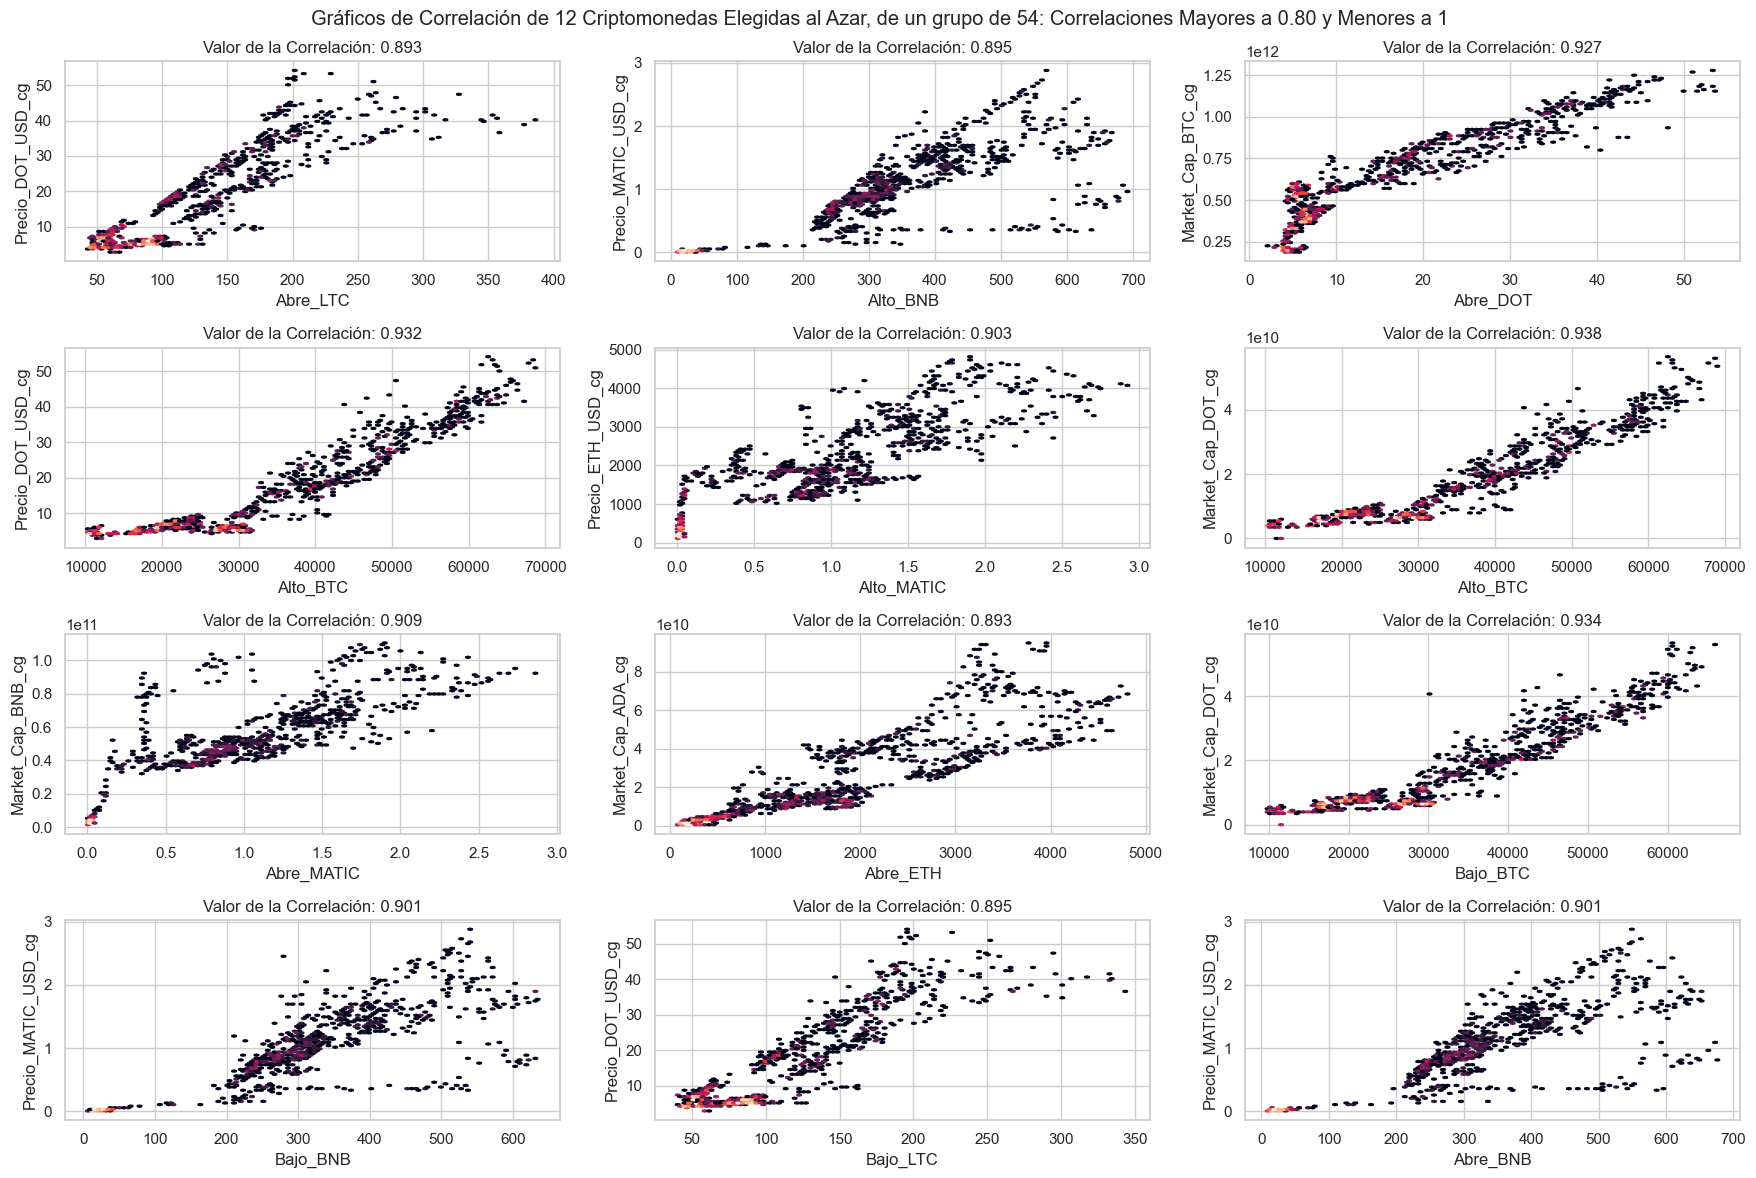

In [1264]:
corr_df = pd.DataFrame(df_bn.merge(df_cg).corr(numeric_only=False).unstack()).reset_index()
full_df = df_bn.merge(df_cg)

corr_df.columns = ['Var1','Var2','Correlacion']
corr_df = corr_df.sort_values(by=['Correlacion','Var1'])[::2].reset_index(drop=True)
corr_df['dummy'] = corr_df.Var1 + corr_df.Var2
corr_df_cg_copy['dummy'] = corr_df_cg_copy.Var1 + corr_df_cg_copy.Var2
corr_df_bn_copy['dummy'] = corr_df_bn_copy.Var1 + corr_df_bn_copy.Var2
corr_df = corr_df[(corr_df.dummy.isin(corr_df_cg_copy.dummy.to_list()) == False) & (corr_df.dummy.isin(corr_df_bn_copy.dummy.to_list()) == False)]
corr_df = corr_df[(corr_df.Correlacion < 1) & (abs(corr_df.Correlacion) >= 0.892)].reset_index(drop=True)

var1_mask = []
var2_mask = []
var3_mask = []
var4_mask = []
masks = []
masks2 = []
j = 0
for i in coins:
    var1_mask.append((corr_df.Var1.str.contains(f'Cap_{i.upper()}')) | (corr_df.Var1.str.contains(f'Volumen_{i.upper()}')) | (corr_df.Var1.str.contains(f'Precio_{i.upper()}_USD_cg')) | (corr_df.Var1.str.contains(f'{i.upper()}_Volumen')))
    var2_mask.append((corr_df.Var2.str.contains(f'Cap_{i.upper()}')) | (corr_df.Var2.str.contains(f'Volumen_{i.upper()}')) | (corr_df.Var2.str.contains(f'Precio_{i.upper()}_USD_cg')) | (corr_df.Var2.str.contains(f'{i.upper()}_Volumen')))
    var3_mask.append((corr_df.Var1.str.contains(f'Alto_{i.upper()}')) | (corr_df.Var1.str.contains(f'Abre_{i.upper()}')) | (corr_df.Var1.str.contains(f'Precio_{i.upper()}_USDT')) | (corr_df.Var1.str.contains(f'Bajo_{i.upper()}')))
    var4_mask.append((corr_df.Var2.str.contains(f'Alto_{i.upper()}')) | (corr_df.Var2.str.contains(f'Abre_{i.upper()}')) | (corr_df.Var2.str.contains(f'Precio_{i.upper()}_USDT')) | (corr_df.Var2.str.contains(f'Bajo_{i.upper()}')))
    masks.append((var1_mask[j] & var2_mask[j]) | (var3_mask[j] & var4_mask[j]))
    masks2.append((var1_mask[j] & var4_mask[j]) | (var3_mask[j] & var2_mask[j]))
    j += 1

indices = []
for i in masks:
    indices.append(corr_df[i].index.to_list())
for i in masks2:
    indices.append(corr_df[i].index.to_list())
btcbnb_cg = (var1_mask[0] & var2_mask[2]) | (var1_mask[2] & var2_mask[0])
bnbeth_cg = (var1_mask[2] & var2_mask[5]) | (var1_mask[5] & var2_mask[2])
btceth_cg = (var1_mask[5] & var2_mask[0]) | (var1_mask[0] & var2_mask[5])
btcbnb_bn = (var3_mask[0] & var4_mask[2]) | (var3_mask[2] & var4_mask[0])
bnbeth_bn = (var3_mask[2] & var4_mask[5]) | (var3_mask[5] & var4_mask[2])
btceth_bn = (var3_mask[5] & var4_mask[0]) | (var3_mask[0] & var4_mask[5])
btcbnb_bc = (var3_mask[0] & var2_mask[2]) | (var3_mask[2] & var2_mask[0]) | (var1_mask[0] & var4_mask[2]) | (var1_mask[2] & var4_mask[0])
bnbeth_bc = (var3_mask[2] & var2_mask[5]) | (var3_mask[5] & var2_mask[2]) | (var1_mask[2] & var4_mask[5]) | (var1_mask[5] & var4_mask[2])
btceth_bc = (var3_mask[5] & var2_mask[0]) | (var3_mask[0] & var2_mask[5]) | (var1_mask[5] & var4_mask[0]) | (var1_mask[0] & var4_mask[5])
indices.append(corr_df[bnbeth_bn | btcbnb_bn | btceth_bn | bnbeth_cg | btcbnb_cg | btceth_cg | bnbeth_bc | btcbnb_bc | btceth_bc].index.to_list())
index_val = []
for i in indices:
    for j in i:
        index_val.append(j)

corr_df = corr_df.drop(index_val).reset_index(drop=True)

index_val = random.sample(list(range(56)),12)

fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(17.75,12))
fig.suptitle('Gráficos de Correlación de 12 Criptomonedas Elegidas al Azar, de un grupo de 54: Correlaciones Mayores a 0.80 y Menores a 1')
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flatten()
lista = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]

for i in range(12):
    lista[i].hexbin(x=full_df[f'{corr_df.Var1[index_val[i]]}'],y=full_df[f'{corr_df.Var2[index_val[i]]}'],bins='log')
    lista[i].set_title(f'Valor de la Correlación: {round(corr_df.Correlacion[index_val[i]],3)}')
    lista[i].set_xlabel(xlabel=f'{corr_df.Var1[index_val[i]]}')
    lista[i].set_ylabel(ylabel=f'{corr_df.Var2[index_val[i]]}')

plt.tight_layout()
plt.show()

### Conclusiones y comentarios al respecto de las correlaciones.

Lo primero que hay que decir es que se trabajó con las correlaciones menos obvias. Se eliminaron correlaciones entre los datos de BNB, ETH y BTC, puesto que ya se conoce la correlación entre dichas criptos, por lo que dejamos correlaciones entre otras criptos que pueden llegar a ser más segnificativas por el hecho de aportar nuevo conocimiento. Esto se hizo en las dos primeras visualizaciones en donde tratamos los datos de binance y coingecko por separado.

Por último, trabajamos con los datos de ambos DF's en conjunto, eliminando las correlaciones que ya se habían dado en las dos visualizaciones anteriores. Además, generamos máscaras similares a las de las dos visualizaciones anteriores, con lo que descartamos las correlaciones típicas y ya conocidas.

Además de todo esto, se limpiaron los datos duplicados en las tres visualizaciones.

Esto quiere decir que en las tres visualizaciones se obtienen gráficos totalmente distintos y complementarios.

Otra de las conclusiones es que se corroboró que las correlaciones conocidas existen y son muy cercanas a la unidad. De entre estos pares de variables, se encontraban muchas correlaciones entre los precios OHCL de binance y los precios de coingecko. Sin embargo, también se encontraron variables para las cuales no existía correlación alguna o incluso existía una correlación negativa.

### Propuesta de Análisis:

La última propuesta es con base en las visualizaciones y los datos que se estuvieron trabajando, creo que es un buen camino de encontrar un KPI, esto porque se podría generar estas mismas correlaciones pero en periodos de tiempo y comparar los valores de correlación para diversos periodos de tiempo y tomar la fecha del halving anterior o la del próximo como medida relativa.

# =========================================================
# Conclusiones Finales

Se crearon gráficos de líneas, histogramas, mapas de calor para las correlaciones, gráficas sobre las mejores correlaciones encontradas e incluso se generó una gráfica de autocorrelación con el fin de mostrar si los datos son datos random o no, a lo cual se determinó que no son datos random.

Con base en todo esto, nos permitimos concluir que las mejores criptomonedas para hacer trading son BTC y ETH debido a su alta volatilidad y su mayor oportunidad de ganancia, sin embargo, los datos también demuestran que son criptomonedas con un riesgo más alto que muchas otras.

Por otra parte, también se concluye que la mejor criptomoneda para realizar transferencias entre intercambios o wallets es XRP.

Después de eso, descubrimos que, después de BTC, ETH y BNB, la criptomoneda más correlacionada con estas tres es TRX y después DOT.

Aunado a esto, vale la pena repetir las primeras conclusiones, bajo las cuales definimos que es necesario trabajar sobre los datos de precios del intercambio, pero sobre los datos de volumen y market cap de coingecko. Sin embargo, más adelante nos encontramos con que es justamente el volumen uno de los parámetros que no se correlaciona con ningún otro parámetro.